In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
%matplotlib inline

In [3]:
df=pd.read_csv("../../../Integrated_data/merged_df_reward.csv",encoding="cp949")

In [4]:
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.interpolated()
        self.abmormaled()
        self.result=self.fill_missing_values()

    # ... (다른 클래스 함수 정의는 여기에 있어야 합니다)

    def interpolated(self):
        temp=[]
        temp2=[]
        for i in df['ID'].unique():
            try:
                temp.append(df[df['ID']==i].interpolate())
            except:
                temp.append(df[df['ID']==i])

        new_df=pd.concat(temp,axis=0)
        new_df.fillna(method='bfill',inplace=True)   
        for i in new_df['ID'].unique():
            temp_df=new_df[new_df['ID']==i].reset_index(drop=True)
            temp_df["height"].fillna(method='bfill',inplace=True)
            temp_df["weight"].fillna(method='bfill',inplace=True)
            temp_df["height"].fillna(method='ffill',inplace=True)
            temp_df["weight"].fillna(method='ffill',inplace=True)
            temp2.append(temp_df)
        new_df=pd.concat(temp2,axis=0)  
        self.df = new_df   
    def gap(self,first, last):
        gap_per=(last-first)/first*100
        return abs(gap_per)
        
    def abmormaled(self):
        temp = []
        for i in self.df['ID'].unique():
            temp_df = self.df[self.df['ID'] == i].reset_index(drop=True)
            for i in range(1, len(temp_df)):
                if temp_df.at[i, 'height'] <= temp_df.at[i - 1, 'height']:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
                if self.gap(temp_df.at[i - 1, 'height'], temp_df.at[i, 'height']) >= 16:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
            temp.append(temp_df)
        new_df2 = pd.concat(temp, axis=0)
        new_df2.reset_index(drop=True, inplace=True)
        self.df = new_df2

    def fill_missing_values(self):
        self.df["step_count"].fillna(self.df["step_count"].median(), inplace=True)
        self.df["burned calory"].fillna(self.df["burned calory"].median(), inplace=True)
        self.df["eat_calory"].fillna(self.df["eat_calory"].median(), inplace=True)
        self.df["Sleep_time"].fillna(self.df["Sleep_time"].median(), inplace=True)
        return self.df
    



In [5]:
import pandas as pd

class TimeSeriesLabeler:
    def __init__(self, term):
        self.term = term
        self.result_df = pd.DataFrame()
        self.labels = []

    def calculate_labels(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            label = []

            for i in range(self.term, len(df_id)):
                previous_days = df_id['weight'].iloc[i - self.term:i]
                current_weight = df_id['weight'].iloc[i]
                if current_weight > previous_days.mean().round(3):
                    label.append(1)
                elif current_weight == previous_days.mean().round(3):
                    label.append(0)
                elif current_weight < previous_days.mean().round(3):
                    label.append(2)
                else:
                    print("error")

            self.labels.extend(label)

    def create_result_df(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            df_id_drop = df_id.drop(index=range(self.term))
            self.result_df = pd.concat([self.result_df, df_id_drop])
        self.result_df['labels']= self.labels
        
    def get_labels(self):
        return self.labels

    def get_result_df(self):
        return self.result_df



In [6]:
for i in range(3):
    globals()['reward_data_{}'.format(i+1)]=pd.read_excel("../../../Integrated_data/merged_df_reward_분리.xlsx",sheet_name = i)
    

In [7]:
# 데이터프레임 리스트 생성
dataframes = [reward_data_1, reward_data_2, reward_data_3]

# 반복문으로 데이터프레임 순차적으로 호출
for i, df in enumerate(dataframes, start=0):
    print(f"Processing reward_data_{i+1}")
    processor = DataProcessor(df)
    globals()['df_{}'.format(i+1)]=processor.result


Processing reward_data_1
Processing reward_data_2
Processing reward_data_3


# ID 별로 일주일 간격으로 몸무게 변화 라벨링(유지:0, 감소:2, 증가:1)

In [8]:
term = 5  # You can set your desired 'term' here

In [9]:
labeler_1 = TimeSeriesLabeler(term)
labeler_1.calculate_labels(df_1)  # Provide your DataFrame 'df' as input
labeler_1.create_result_df(df_1)  # Create the result DataFrame
labels = labeler_1.get_labels()
result_df_1 = labeler_1.get_result_df()

In [10]:
labeler_2 = TimeSeriesLabeler(term)
labeler_2.calculate_labels(df_2)  # Provide your DataFrame 'df' as input
labeler_2.create_result_df(df_2)  # Create the result DataFrame
labels = labeler_2.get_labels()
result_df_2 = labeler_2.get_result_df()

In [11]:
labeler_3 = TimeSeriesLabeler(term)
labeler_3.calculate_labels(df_3)  # Provide your DataFrame 'df' as input
labeler_3.create_result_df(df_3)  # Create the result DataFrame
labels = labeler_3.get_labels()
result_df_3 = labeler_3.get_result_df()

# Reward 1에 원래 있는데 Reward 3에 있는 ID 추가

In [12]:
add_ID=['#ZHWQTF','#TRJDPD','#LWQUGV','#TBXKMG']

for name in add_ID:
    add_df=result_df_3[result_df_3['ID']==name]
    result_df_1=pd.concat([result_df_1,add_df], axis=0)

result_df_1.shape

(38055, 12)

In [13]:
result_df_1.shape

(38055, 12)

# 데이터 세트 로드

In [14]:
df_1.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부
0,#AEGMOD,2022-07-14,2,4,132.0,29.00,100.0,8.877,421.0,12.0,1
1,#AEGMOD,2022-07-15,2,4,132.0,29.00,100.0,8.877,421.0,12.0,1
2,#AEGMOD,2022-07-16,2,4,132.0,29.00,100.0,8.877,421.0,12.0,1
3,#AEGMOD,2022-07-17,2,4,133.3,27.25,100.0,8.877,421.0,12.0,1
4,#AEGMOD,2022-07-18,2,4,133.3,27.25,1129.0,8.877,266.0,12.0,1


In [31]:
X_1=result_df_1.iloc[:,[4,5,6,7,8,9]]
y_1=result_df_1.iloc[:,-1].reset_index(drop=
                                      
                                      
                                      
                                      )


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

scaler_1 = StandardScaler()


X_scaler_1=scaler_1.fit_transform(X_1)


smote_1 = SMOTE(random_state=0)
X_over_1,y_over_1 = smote_1.fit_resample(X_scaler_1,y_1)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_1.shape, y_1.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_1.shape, y_over_1.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_1).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_1).value_counts())





SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (38055, 6) (38055,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (102111, 6) (102111,)
SMOTE 적용 전 레이블 값 분포: 
 0    34037
1     2464
2     1554
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    34037
0    34037
1    34037
Name: labels, dtype: int64


# 데이터 스케일링

## Train, Test dataset 나누기

In [33]:
y_over_1

0         2
1         2
2         2
3         0
4         0
         ..
102106    2
102107    2
102108    2
102109    2
102110    2
Name: labels, Length: 102111, dtype: int64

In [34]:
y_1

0        2
1        2
2        2
3        0
4        0
        ..
38050    0
38051    0
38052    0
38053    0
38054    2
Name: labels, Length: 38055, dtype: int64

In [35]:
X_train_over=X_scaler_1
y_train_over=y_1

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.87307. Saving Model!
epoch 01, loss: 1.03175, acc: 0.64884, val_loss: 0.87307, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


[INFO] val_acc has been improved from 0.87307 to 0.60721. Saving Model!
epoch 02, loss: 0.77476, acc: 0.89442, val_loss: 0.60721, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


[INFO] val_acc has been improved from 0.60721 to 0.47374. Saving Model!
epoch 03, loss: 0.53145, acc: 0.89442, val_loss: 0.47374, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 04, loss: 0.45964, acc: 0.89442, val_loss: 0.52694, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 05, loss: 0.49060, acc: 0.89442, val_loss: 0.52400, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 06, loss: 0.46326, acc: 0.89442, val_loss: 0.47579, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.11it/s]


[INFO] val_acc has been improved from 0.47374 to 0.45766. Saving Model!
epoch 07, loss: 0.42913, acc: 0.89442, val_loss: 0.45766, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.52it/s]


epoch 08, loss: 0.42893, acc: 0.89442, val_loss: 0.45853, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.45766 to 0.45100. Saving Model!
epoch 09, loss: 0.43186, acc: 0.89442, val_loss: 0.45100, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81it/s]


[INFO] val_acc has been improved from 0.45100 to 0.44582. Saving Model!
epoch 10, loss: 0.42150, acc: 0.89442, val_loss: 0.44582, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.05it/s]


epoch 11, loss: 0.41421, acc: 0.89442, val_loss: 0.45021, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.87it/s]


epoch 12, loss: 0.41443, acc: 0.89442, val_loss: 0.45060, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.05it/s]


[INFO] val_acc has been improved from 0.44582 to 0.44393. Saving Model!
epoch 13, loss: 0.41258, acc: 0.89442, val_loss: 0.44393, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.17it/s]


[INFO] val_acc has been improved from 0.44393 to 0.43891. Saving Model!
epoch 14, loss: 0.40924, acc: 0.89442, val_loss: 0.43891, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.02it/s]


[INFO] val_acc has been improved from 0.43891 to 0.43736. Saving Model!
epoch 15, loss: 0.40797, acc: 0.89442, val_loss: 0.43736, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


[INFO] val_acc has been improved from 0.43736 to 0.43722. Saving Model!
epoch 16, loss: 0.40662, acc: 0.89442, val_loss: 0.43722, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 17, loss: 0.40503, acc: 0.89442, val_loss: 0.43763, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.43722 to 0.43672. Saving Model!
epoch 18, loss: 0.40411, acc: 0.89442, val_loss: 0.43672, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


[INFO] val_acc has been improved from 0.43672 to 0.43441. Saving Model!
epoch 19, loss: 0.40297, acc: 0.89442, val_loss: 0.43441, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


[INFO] val_acc has been improved from 0.43441 to 0.43272. Saving Model!
epoch 20, loss: 0.40194, acc: 0.89442, val_loss: 0.43272, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.43272 to 0.43199. Saving Model!
epoch 21, loss: 0.40111, acc: 0.89442, val_loss: 0.43199, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.43199 to 0.43148. Saving Model!
epoch 22, loss: 0.40023, acc: 0.89442, val_loss: 0.43148, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.43148 to 0.43028. Saving Model!
epoch 23, loss: 0.39941, acc: 0.89442, val_loss: 0.43028, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.43028 to 0.42911. Saving Model!
epoch 24, loss: 0.39856, acc: 0.89442, val_loss: 0.42911, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.42911 to 0.42843. Saving Model!
epoch 25, loss: 0.39780, acc: 0.89442, val_loss: 0.42843, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.59it/s]


[INFO] val_acc has been improved from 0.42843 to 0.42801. Saving Model!
epoch 26, loss: 0.39707, acc: 0.89442, val_loss: 0.42801, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]


[INFO] val_acc has been improved from 0.42801 to 0.42749. Saving Model!
epoch 27, loss: 0.39635, acc: 0.89442, val_loss: 0.42749, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.69it/s]


[INFO] val_acc has been improved from 0.42749 to 0.42697. Saving Model!
epoch 28, loss: 0.39565, acc: 0.89442, val_loss: 0.42697, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


[INFO] val_acc has been improved from 0.42697 to 0.42656. Saving Model!
epoch 29, loss: 0.39498, acc: 0.89445, val_loss: 0.42656, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.42656 to 0.42632. Saving Model!
epoch 30, loss: 0.39431, acc: 0.89445, val_loss: 0.42632, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83it/s]


[INFO] val_acc has been improved from 0.42632 to 0.42586. Saving Model!
epoch 31, loss: 0.39363, acc: 0.89448, val_loss: 0.42586, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.42586 to 0.42551. Saving Model!
epoch 32, loss: 0.39292, acc: 0.89460, val_loss: 0.42551, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.02it/s]


epoch 33, loss: 0.39226, acc: 0.89460, val_loss: 0.42559, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63it/s]


epoch 34, loss: 0.39160, acc: 0.89462, val_loss: 0.42565, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 35, loss: 0.39094, acc: 0.89462, val_loss: 0.42561, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.42551 to 0.42549. Saving Model!
epoch 36, loss: 0.39029, acc: 0.89462, val_loss: 0.42549, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 37, loss: 0.38962, acc: 0.89462, val_loss: 0.42550, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 38, loss: 0.38895, acc: 0.89460, val_loss: 0.42550, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 39, loss: 0.38826, acc: 0.89462, val_loss: 0.42577, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 40, loss: 0.38751, acc: 0.89462, val_loss: 0.42583, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 41, loss: 0.38682, acc: 0.89465, val_loss: 0.42561, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 42, loss: 0.38612, acc: 0.89468, val_loss: 0.42610, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 43, loss: 0.38541, acc: 0.89468, val_loss: 0.42649, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 44, loss: 0.38468, acc: 0.89468, val_loss: 0.42630, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 45, loss: 0.38399, acc: 0.89468, val_loss: 0.42659, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 46, loss: 0.38319, acc: 0.89468, val_loss: 0.42646, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 47, loss: 0.38248, acc: 0.89468, val_loss: 0.42682, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20it/s]


epoch 48, loss: 0.38176, acc: 0.89471, val_loss: 0.42754, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 49, loss: 0.38100, acc: 0.89471, val_loss: 0.42780, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 50, loss: 0.38026, acc: 0.89471, val_loss: 0.42749, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44it/s]


epoch 51, loss: 0.37948, acc: 0.89471, val_loss: 0.42773, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25it/s]


epoch 52, loss: 0.37871, acc: 0.89471, val_loss: 0.42815, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 53, loss: 0.37790, acc: 0.89471, val_loss: 0.42889, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 54, loss: 0.37712, acc: 0.89474, val_loss: 0.42922, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 55, loss: 0.37624, acc: 0.89474, val_loss: 0.42954, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 56, loss: 0.37549, acc: 0.89480, val_loss: 0.42996, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 57, loss: 0.37467, acc: 0.89477, val_loss: 0.43103, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 58, loss: 0.37371, acc: 0.89471, val_loss: 0.43149, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 59, loss: 0.37298, acc: 0.89480, val_loss: 0.43257, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 60, loss: 0.37198, acc: 0.89480, val_loss: 0.43292, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 61, loss: 0.37127, acc: 0.89480, val_loss: 0.43323, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 62, loss: 0.37027, acc: 0.89477, val_loss: 0.43407, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 63, loss: 0.36951, acc: 0.89468, val_loss: 0.43484, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 64, loss: 0.36880, acc: 0.89483, val_loss: 0.43610, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 65, loss: 0.36776, acc: 0.89486, val_loss: 0.43708, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55it/s]


epoch 66, loss: 0.36691, acc: 0.89489, val_loss: 0.43749, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 67, loss: 0.36566, acc: 0.89506, val_loss: 0.44057, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 68, loss: 0.36470, acc: 0.89495, val_loss: 0.44108, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.93it/s]


epoch 69, loss: 0.36406, acc: 0.89500, val_loss: 0.44349, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.27it/s]


epoch 70, loss: 0.36285, acc: 0.89512, val_loss: 0.44176, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 71, loss: 0.36201, acc: 0.89509, val_loss: 0.44266, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55it/s]


epoch 72, loss: 0.36132, acc: 0.89512, val_loss: 0.44753, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 73, loss: 0.36034, acc: 0.89547, val_loss: 0.44359, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 74, loss: 0.36020, acc: 0.89495, val_loss: 0.45006, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 75, loss: 0.36040, acc: 0.89492, val_loss: 0.44705, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 76, loss: 0.35879, acc: 0.89582, val_loss: 0.45294, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 77, loss: 0.35816, acc: 0.89521, val_loss: 0.45345, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 78, loss: 0.35729, acc: 0.89568, val_loss: 0.44294, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 79, loss: 0.35478, acc: 0.89585, val_loss: 0.44877, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 80, loss: 0.35446, acc: 0.89568, val_loss: 0.45877, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 81, loss: 0.35401, acc: 0.90090, val_loss: 0.44646, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 82, loss: 0.35313, acc: 0.90073, val_loss: 0.45755, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 83, loss: 0.35247, acc: 0.90122, val_loss: 0.45016, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 84, loss: 0.35095, acc: 0.90111, val_loss: 0.45515, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 85, loss: 0.35030, acc: 0.90073, val_loss: 0.45944, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 86, loss: 0.34987, acc: 0.90090, val_loss: 0.45363, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 87, loss: 0.34838, acc: 0.90119, val_loss: 0.45811, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 88, loss: 0.34857, acc: 0.90081, val_loss: 0.46554, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 89, loss: 0.34813, acc: 0.90073, val_loss: 0.45510, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 90, loss: 0.34690, acc: 0.90131, val_loss: 0.46596, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 91, loss: 0.34709, acc: 0.90084, val_loss: 0.47009, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 92, loss: 0.34610, acc: 0.90041, val_loss: 0.45898, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 93, loss: 0.34431, acc: 0.90137, val_loss: 0.47162, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 94, loss: 0.34560, acc: 0.90084, val_loss: 0.47799, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 95, loss: 0.34461, acc: 0.90044, val_loss: 0.45779, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 96, loss: 0.34365, acc: 0.90146, val_loss: 0.48738, val_accuracy: 0.89306


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 97, loss: 0.34338, acc: 0.90114, val_loss: 0.47363, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 98, loss: 0.34170, acc: 0.90122, val_loss: 0.46376, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 99, loss: 0.34032, acc: 0.90125, val_loss: 0.48367, val_accuracy: 0.89359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 100, loss: 0.34151, acc: 0.90099, val_loss: 0.48963, val_accuracy: 0.89044


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 101, loss: 0.33982, acc: 0.90046, val_loss: 0.46582, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 102, loss: 0.33967, acc: 0.90157, val_loss: 0.49410, val_accuracy: 0.87835


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 103, loss: 0.33859, acc: 0.90131, val_loss: 0.47936, val_accuracy: 0.89648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 104, loss: 0.33728, acc: 0.90096, val_loss: 0.47840, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 105, loss: 0.33656, acc: 0.90169, val_loss: 0.49019, val_accuracy: 0.87914


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 106, loss: 0.33674, acc: 0.90146, val_loss: 0.49440, val_accuracy: 0.87599


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 107, loss: 0.33540, acc: 0.90099, val_loss: 0.48743, val_accuracy: 0.87599


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 108, loss: 0.33525, acc: 0.90081, val_loss: 0.49264, val_accuracy: 0.87599


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00it/s]


epoch 109, loss: 0.33519, acc: 0.90160, val_loss: 0.49694, val_accuracy: 0.86942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 110, loss: 0.33468, acc: 0.90099, val_loss: 0.51125, val_accuracy: 0.86837


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 111, loss: 0.33369, acc: 0.90143, val_loss: 0.48663, val_accuracy: 0.87809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 112, loss: 0.33590, acc: 0.90032, val_loss: 0.51231, val_accuracy: 0.84419


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 113, loss: 0.33486, acc: 0.90108, val_loss: 0.51251, val_accuracy: 0.86784


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 114, loss: 0.33310, acc: 0.90166, val_loss: 0.49705, val_accuracy: 0.87599


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 115, loss: 0.33514, acc: 0.90052, val_loss: 0.51452, val_accuracy: 0.83946


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 116, loss: 0.33514, acc: 0.90131, val_loss: 0.54314, val_accuracy: 0.83552


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 117, loss: 0.33368, acc: 0.90090, val_loss: 0.49727, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 118, loss: 0.33648, acc: 0.90046, val_loss: 0.52699, val_accuracy: 0.83605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 119, loss: 0.33357, acc: 0.90128, val_loss: 0.51662, val_accuracy: 0.84735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 120, loss: 0.33079, acc: 0.90079, val_loss: 0.50168, val_accuracy: 0.87756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 121, loss: 0.33332, acc: 0.90108, val_loss: 0.57764, val_accuracy: 0.82738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 122, loss: 0.33396, acc: 0.90079, val_loss: 0.50719, val_accuracy: 0.85208


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 123, loss: 0.33137, acc: 0.90125, val_loss: 0.49902, val_accuracy: 0.87599


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 124, loss: 0.33654, acc: 0.90184, val_loss: 0.59573, val_accuracy: 0.82712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 125, loss: 0.33258, acc: 0.90251, val_loss: 0.49027, val_accuracy: 0.88991


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00it/s]


epoch 126, loss: 0.33042, acc: 0.90093, val_loss: 0.53938, val_accuracy: 0.83473


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 127, loss: 0.33222, acc: 0.90149, val_loss: 0.58215, val_accuracy: 0.82475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 128, loss: 0.33034, acc: 0.90137, val_loss: 0.49296, val_accuracy: 0.88991


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 129, loss: 0.33112, acc: 0.90093, val_loss: 0.57173, val_accuracy: 0.83106


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 130, loss: 0.32906, acc: 0.90114, val_loss: 0.52853, val_accuracy: 0.83710


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 131, loss: 0.32695, acc: 0.90201, val_loss: 0.50711, val_accuracy: 0.85286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 132, loss: 0.32702, acc: 0.90230, val_loss: 0.59641, val_accuracy: 0.82370


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 133, loss: 0.32657, acc: 0.90207, val_loss: 0.53055, val_accuracy: 0.83657


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 134, loss: 0.32591, acc: 0.90140, val_loss: 0.52504, val_accuracy: 0.83605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 135, loss: 0.32614, acc: 0.90213, val_loss: 0.58614, val_accuracy: 0.82449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 136, loss: 0.32443, acc: 0.90251, val_loss: 0.52378, val_accuracy: 0.83868


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 137, loss: 0.32527, acc: 0.90111, val_loss: 0.56432, val_accuracy: 0.82659


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s]


epoch 138, loss: 0.32404, acc: 0.90239, val_loss: 0.56728, val_accuracy: 0.82633


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44it/s]


epoch 139, loss: 0.32270, acc: 0.90262, val_loss: 0.52993, val_accuracy: 0.83710


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 140, loss: 0.32485, acc: 0.90192, val_loss: 0.60040, val_accuracy: 0.82265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.04it/s]


epoch 141, loss: 0.32262, acc: 0.90262, val_loss: 0.54281, val_accuracy: 0.83158


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.61it/s]


epoch 142, loss: 0.32168, acc: 0.90187, val_loss: 0.53755, val_accuracy: 0.83579


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 143, loss: 0.32344, acc: 0.90163, val_loss: 0.62968, val_accuracy: 0.82291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 144, loss: 0.32240, acc: 0.90335, val_loss: 0.53738, val_accuracy: 0.83473


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 145, loss: 0.32197, acc: 0.90192, val_loss: 0.54860, val_accuracy: 0.83132


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 146, loss: 0.32261, acc: 0.90166, val_loss: 0.62246, val_accuracy: 0.82317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 147, loss: 0.32129, acc: 0.90298, val_loss: 0.53547, val_accuracy: 0.83605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 148, loss: 0.32175, acc: 0.90189, val_loss: 0.57454, val_accuracy: 0.82790


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 149, loss: 0.32073, acc: 0.90265, val_loss: 0.59994, val_accuracy: 0.82422


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 150, loss: 0.31876, acc: 0.90292, val_loss: 0.54673, val_accuracy: 0.83368


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 151, loss: 0.32112, acc: 0.90230, val_loss: 0.61673, val_accuracy: 0.82422


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 152, loss: 0.31911, acc: 0.90295, val_loss: 0.57383, val_accuracy: 0.82685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 153, loss: 0.31755, acc: 0.90298, val_loss: 0.55382, val_accuracy: 0.83237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 154, loss: 0.32079, acc: 0.90219, val_loss: 0.63939, val_accuracy: 0.82317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 155, loss: 0.31832, acc: 0.90362, val_loss: 0.55542, val_accuracy: 0.82738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 156, loss: 0.31742, acc: 0.90262, val_loss: 0.56469, val_accuracy: 0.82790


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 157, loss: 0.31915, acc: 0.90219, val_loss: 0.64741, val_accuracy: 0.82344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]


epoch 158, loss: 0.31672, acc: 0.90368, val_loss: 0.56660, val_accuracy: 0.82633


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 159, loss: 0.31635, acc: 0.90286, val_loss: 0.58177, val_accuracy: 0.82712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 160, loss: 0.31668, acc: 0.90242, val_loss: 0.63570, val_accuracy: 0.82344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 161, loss: 0.31466, acc: 0.90347, val_loss: 0.57859, val_accuracy: 0.82554


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 162, loss: 0.31531, acc: 0.90306, val_loss: 0.59337, val_accuracy: 0.82712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 163, loss: 0.31465, acc: 0.90347, val_loss: 0.62666, val_accuracy: 0.82344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 164, loss: 0.31265, acc: 0.90321, val_loss: 0.60181, val_accuracy: 0.82554


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 165, loss: 0.31329, acc: 0.90321, val_loss: 0.59639, val_accuracy: 0.82685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 166, loss: 0.31282, acc: 0.90379, val_loss: 0.61708, val_accuracy: 0.82291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 167, loss: 0.31140, acc: 0.90338, val_loss: 0.62817, val_accuracy: 0.82265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 168, loss: 0.31123, acc: 0.90365, val_loss: 0.59584, val_accuracy: 0.82606


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 169, loss: 0.31204, acc: 0.90432, val_loss: 0.61336, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 170, loss: 0.31106, acc: 0.90391, val_loss: 0.63657, val_accuracy: 0.82239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 171, loss: 0.31006, acc: 0.90446, val_loss: 0.61107, val_accuracy: 0.82501


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 172, loss: 0.31065, acc: 0.90376, val_loss: 0.59901, val_accuracy: 0.82606


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 173, loss: 0.31202, acc: 0.90298, val_loss: 0.65913, val_accuracy: 0.81844


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 174, loss: 0.31115, acc: 0.90397, val_loss: 0.63966, val_accuracy: 0.82081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 175, loss: 0.31042, acc: 0.90572, val_loss: 0.60270, val_accuracy: 0.82580


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 176, loss: 0.31275, acc: 0.90376, val_loss: 0.60583, val_accuracy: 0.82580


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.05it/s]


epoch 177, loss: 0.31273, acc: 0.90333, val_loss: 0.69540, val_accuracy: 0.81555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.30it/s]


epoch 178, loss: 0.31347, acc: 0.90365, val_loss: 0.63139, val_accuracy: 0.82186


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 179, loss: 0.31390, acc: 0.90321, val_loss: 0.59540, val_accuracy: 0.82580


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.11it/s]


epoch 180, loss: 0.31699, acc: 0.90298, val_loss: 0.64754, val_accuracy: 0.82002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.14it/s]


epoch 181, loss: 0.31189, acc: 0.90400, val_loss: 0.66827, val_accuracy: 0.81976


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.02it/s]


epoch 182, loss: 0.31063, acc: 0.90648, val_loss: 0.61220, val_accuracy: 0.82528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


epoch 183, loss: 0.31386, acc: 0.90265, val_loss: 0.64232, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.81it/s]


epoch 184, loss: 0.31083, acc: 0.90344, val_loss: 0.66501, val_accuracy: 0.81792


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 185, loss: 0.30913, acc: 0.90540, val_loss: 0.61865, val_accuracy: 0.82396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.17it/s]


epoch 186, loss: 0.31036, acc: 0.90344, val_loss: 0.63446, val_accuracy: 0.82501


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25it/s]


epoch 187, loss: 0.31213, acc: 0.90382, val_loss: 0.68580, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 188, loss: 0.30779, acc: 0.90592, val_loss: 0.63898, val_accuracy: 0.82396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


epoch 189, loss: 0.30764, acc: 0.90654, val_loss: 0.63614, val_accuracy: 0.82239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 190, loss: 0.30785, acc: 0.90432, val_loss: 0.67284, val_accuracy: 0.81792


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 191, loss: 0.30503, acc: 0.90508, val_loss: 0.64587, val_accuracy: 0.82449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 192, loss: 0.30459, acc: 0.90651, val_loss: 0.65875, val_accuracy: 0.81844


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 193, loss: 0.30421, acc: 0.90528, val_loss: 0.64490, val_accuracy: 0.82107


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.38it/s]


epoch 194, loss: 0.30536, acc: 0.90487, val_loss: 0.67902, val_accuracy: 0.81713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 195, loss: 0.30443, acc: 0.90572, val_loss: 0.66973, val_accuracy: 0.81871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 196, loss: 0.30412, acc: 0.90671, val_loss: 0.64621, val_accuracy: 0.82239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 197, loss: 0.30594, acc: 0.90519, val_loss: 0.65604, val_accuracy: 0.82107


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31it/s]


epoch 198, loss: 0.30552, acc: 0.90455, val_loss: 0.73059, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 199, loss: 0.30613, acc: 0.90601, val_loss: 0.65936, val_accuracy: 0.81844


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55it/s]


epoch 200, loss: 0.30697, acc: 0.90484, val_loss: 0.63360, val_accuracy: 0.82265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31it/s]


epoch 201, loss: 0.30911, acc: 0.90441, val_loss: 0.68537, val_accuracy: 0.81766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 202, loss: 0.30474, acc: 0.90604, val_loss: 0.71651, val_accuracy: 0.81555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 203, loss: 0.30400, acc: 0.90630, val_loss: 0.66505, val_accuracy: 0.81739


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 204, loss: 0.30649, acc: 0.90496, val_loss: 0.65937, val_accuracy: 0.82186


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 205, loss: 0.30667, acc: 0.90476, val_loss: 0.70691, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 206, loss: 0.30354, acc: 0.90721, val_loss: 0.69435, val_accuracy: 0.81739


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 207, loss: 0.30313, acc: 0.90712, val_loss: 0.66634, val_accuracy: 0.82291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 208, loss: 0.30609, acc: 0.90400, val_loss: 0.69862, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 209, loss: 0.30286, acc: 0.90665, val_loss: 0.70801, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28it/s]


epoch 210, loss: 0.30110, acc: 0.90768, val_loss: 0.68173, val_accuracy: 0.81713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 211, loss: 0.30273, acc: 0.90598, val_loss: 0.67354, val_accuracy: 0.82212


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 212, loss: 0.30455, acc: 0.90540, val_loss: 0.73129, val_accuracy: 0.81398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28it/s]


epoch 213, loss: 0.30305, acc: 0.90651, val_loss: 0.72365, val_accuracy: 0.81555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 214, loss: 0.30225, acc: 0.90715, val_loss: 0.66963, val_accuracy: 0.82265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 215, loss: 0.30603, acc: 0.90484, val_loss: 0.71722, val_accuracy: 0.81555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 216, loss: 0.30296, acc: 0.90660, val_loss: 0.75149, val_accuracy: 0.81398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 217, loss: 0.30129, acc: 0.90782, val_loss: 0.68828, val_accuracy: 0.81976


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 218, loss: 0.30275, acc: 0.90590, val_loss: 0.69533, val_accuracy: 0.82002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 219, loss: 0.30273, acc: 0.90578, val_loss: 0.74580, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


epoch 220, loss: 0.29969, acc: 0.90776, val_loss: 0.71972, val_accuracy: 0.81582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


epoch 221, loss: 0.29908, acc: 0.90762, val_loss: 0.68921, val_accuracy: 0.82002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s]


epoch 222, loss: 0.30163, acc: 0.90519, val_loss: 0.74323, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28it/s]


epoch 223, loss: 0.29841, acc: 0.90794, val_loss: 0.72378, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 224, loss: 0.29676, acc: 0.90823, val_loss: 0.72353, val_accuracy: 0.81608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 225, loss: 0.29729, acc: 0.90668, val_loss: 0.70375, val_accuracy: 0.82002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31it/s]


epoch 226, loss: 0.29981, acc: 0.90648, val_loss: 0.76883, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 227, loss: 0.30000, acc: 0.90703, val_loss: 0.74569, val_accuracy: 0.81345


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


epoch 228, loss: 0.29877, acc: 0.90756, val_loss: 0.70104, val_accuracy: 0.82055


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 229, loss: 0.30130, acc: 0.90636, val_loss: 0.73372, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 230, loss: 0.30000, acc: 0.90642, val_loss: 0.81410, val_accuracy: 0.81188


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 231, loss: 0.29967, acc: 0.90861, val_loss: 0.70459, val_accuracy: 0.81950


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 232, loss: 0.30067, acc: 0.90642, val_loss: 0.71870, val_accuracy: 0.81687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 233, loss: 0.29899, acc: 0.90636, val_loss: 0.76523, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 234, loss: 0.29780, acc: 0.90706, val_loss: 0.76231, val_accuracy: 0.81345


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25it/s]


epoch 235, loss: 0.29712, acc: 0.90791, val_loss: 0.71008, val_accuracy: 0.82081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


epoch 236, loss: 0.30190, acc: 0.90627, val_loss: 0.77114, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 237, loss: 0.29685, acc: 0.90806, val_loss: 0.78276, val_accuracy: 0.81398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 238, loss: 0.29450, acc: 0.90864, val_loss: 0.72715, val_accuracy: 0.81687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 239, loss: 0.29476, acc: 0.90712, val_loss: 0.74791, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 240, loss: 0.29536, acc: 0.90782, val_loss: 0.79398, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 241, loss: 0.29383, acc: 0.90873, val_loss: 0.73850, val_accuracy: 0.81634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 242, loss: 0.29399, acc: 0.90861, val_loss: 0.72459, val_accuracy: 0.81950


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 243, loss: 0.29540, acc: 0.90741, val_loss: 0.77731, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 244, loss: 0.29495, acc: 0.90820, val_loss: 0.81838, val_accuracy: 0.81293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 245, loss: 0.29467, acc: 0.90832, val_loss: 0.72111, val_accuracy: 0.82055


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87it/s]


epoch 246, loss: 0.29818, acc: 0.90651, val_loss: 0.75797, val_accuracy: 0.81582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 247, loss: 0.29480, acc: 0.90738, val_loss: 0.80096, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 248, loss: 0.29408, acc: 0.90765, val_loss: 0.78169, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 249, loss: 0.29414, acc: 0.90803, val_loss: 0.73536, val_accuracy: 0.82081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 250, loss: 0.29889, acc: 0.90706, val_loss: 0.80124, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 251, loss: 0.29446, acc: 0.90861, val_loss: 0.80693, val_accuracy: 0.81372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.05it/s]


epoch 252, loss: 0.29159, acc: 0.90949, val_loss: 0.74763, val_accuracy: 0.81713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


epoch 253, loss: 0.29212, acc: 0.90721, val_loss: 0.77250, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.39it/s]


epoch 254, loss: 0.29270, acc: 0.90806, val_loss: 0.82361, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s]


epoch 255, loss: 0.29107, acc: 0.90896, val_loss: 0.75500, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78it/s]


epoch 256, loss: 0.29169, acc: 0.90899, val_loss: 0.74929, val_accuracy: 0.81976


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 257, loss: 0.29320, acc: 0.90788, val_loss: 0.81248, val_accuracy: 0.81398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 258, loss: 0.29324, acc: 0.90735, val_loss: 0.84569, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 259, loss: 0.29313, acc: 0.90826, val_loss: 0.74464, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 260, loss: 0.29759, acc: 0.90698, val_loss: 0.78633, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.36it/s]


epoch 261, loss: 0.29263, acc: 0.90844, val_loss: 0.83109, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.17it/s]


epoch 262, loss: 0.28966, acc: 0.90911, val_loss: 0.78242, val_accuracy: 0.81634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64it/s]


epoch 263, loss: 0.28992, acc: 0.90858, val_loss: 0.77217, val_accuracy: 0.81582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.02it/s]


epoch 264, loss: 0.29174, acc: 0.90841, val_loss: 0.82748, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


epoch 265, loss: 0.29003, acc: 0.90846, val_loss: 0.82264, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 266, loss: 0.28891, acc: 0.90917, val_loss: 0.76188, val_accuracy: 0.81608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


epoch 267, loss: 0.29238, acc: 0.90788, val_loss: 0.80340, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.08it/s]


epoch 268, loss: 0.28974, acc: 0.90887, val_loss: 0.85329, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 269, loss: 0.28930, acc: 0.90841, val_loss: 0.81781, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.11it/s]


epoch 270, loss: 0.28938, acc: 0.90917, val_loss: 0.76373, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.72it/s]


epoch 271, loss: 0.29499, acc: 0.90768, val_loss: 0.83163, val_accuracy: 0.81214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


epoch 272, loss: 0.29015, acc: 0.90841, val_loss: 0.84354, val_accuracy: 0.81266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 273, loss: 0.28712, acc: 0.90946, val_loss: 0.79654, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 274, loss: 0.28762, acc: 0.90852, val_loss: 0.79923, val_accuracy: 0.81555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 275, loss: 0.28911, acc: 0.90893, val_loss: 0.86267, val_accuracy: 0.80715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41it/s]


epoch 276, loss: 0.28857, acc: 0.90934, val_loss: 0.80988, val_accuracy: 0.81293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 277, loss: 0.28882, acc: 0.90917, val_loss: 0.78275, val_accuracy: 0.81818


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 278, loss: 0.29123, acc: 0.90800, val_loss: 0.83913, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 279, loss: 0.28847, acc: 0.90905, val_loss: 0.88969, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 280, loss: 0.28823, acc: 0.90849, val_loss: 0.80596, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 281, loss: 0.29009, acc: 0.90808, val_loss: 0.81102, val_accuracy: 0.81450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 282, loss: 0.28858, acc: 0.90884, val_loss: 0.85113, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 283, loss: 0.28501, acc: 0.90943, val_loss: 0.84995, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 284, loss: 0.28468, acc: 0.91013, val_loss: 0.81058, val_accuracy: 0.81582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 285, loss: 0.28678, acc: 0.90887, val_loss: 0.84651, val_accuracy: 0.81214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 286, loss: 0.28667, acc: 0.90829, val_loss: 0.88295, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 287, loss: 0.28562, acc: 0.90963, val_loss: 0.80652, val_accuracy: 0.81555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


epoch 288, loss: 0.28908, acc: 0.90858, val_loss: 0.82405, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 289, loss: 0.28811, acc: 0.90890, val_loss: 0.89038, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 290, loss: 0.28566, acc: 0.90922, val_loss: 0.88160, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 291, loss: 0.28541, acc: 0.91007, val_loss: 0.80448, val_accuracy: 0.81976


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 292, loss: 0.28957, acc: 0.90890, val_loss: 0.85495, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 293, loss: 0.28571, acc: 0.90914, val_loss: 0.88116, val_accuracy: 0.80872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 294, loss: 0.28373, acc: 0.91007, val_loss: 0.85132, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 295, loss: 0.28465, acc: 0.91016, val_loss: 0.82719, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06it/s]


epoch 296, loss: 0.28732, acc: 0.90911, val_loss: 0.88622, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 297, loss: 0.28390, acc: 0.90943, val_loss: 0.89628, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 298, loss: 0.28235, acc: 0.91060, val_loss: 0.84860, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 299, loss: 0.28374, acc: 0.91013, val_loss: 0.84866, val_accuracy: 0.81424


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 300, loss: 0.28307, acc: 0.90966, val_loss: 0.88864, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 301, loss: 0.28125, acc: 0.91010, val_loss: 0.88403, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 302, loss: 0.28135, acc: 0.91103, val_loss: 0.84037, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 303, loss: 0.28379, acc: 0.90934, val_loss: 0.86917, val_accuracy: 0.81266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 304, loss: 0.28318, acc: 0.90946, val_loss: 0.94657, val_accuracy: 0.80767


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 305, loss: 0.28310, acc: 0.91025, val_loss: 0.84634, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24it/s]


epoch 306, loss: 0.28634, acc: 0.90914, val_loss: 0.84839, val_accuracy: 0.81424


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 307, loss: 0.28516, acc: 0.90954, val_loss: 0.90453, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 308, loss: 0.28609, acc: 0.90867, val_loss: 0.95483, val_accuracy: 0.80767


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 309, loss: 0.28686, acc: 0.90975, val_loss: 0.82729, val_accuracy: 0.81923


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 310, loss: 0.29404, acc: 0.90887, val_loss: 0.86994, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 311, loss: 0.28743, acc: 0.90899, val_loss: 0.95723, val_accuracy: 0.80662


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 312, loss: 0.28394, acc: 0.91030, val_loss: 0.86837, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 313, loss: 0.28430, acc: 0.90917, val_loss: 0.86298, val_accuracy: 0.81450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 314, loss: 0.28340, acc: 0.90917, val_loss: 0.90882, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 315, loss: 0.28414, acc: 0.90884, val_loss: 0.91325, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 316, loss: 0.28335, acc: 0.91019, val_loss: 0.84106, val_accuracy: 0.81766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 317, loss: 0.28893, acc: 0.90943, val_loss: 0.92705, val_accuracy: 0.81109


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


epoch 318, loss: 0.28281, acc: 0.90972, val_loss: 0.93279, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 319, loss: 0.27960, acc: 0.91045, val_loss: 0.87199, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44it/s]


epoch 320, loss: 0.27982, acc: 0.91092, val_loss: 0.90738, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41it/s]


epoch 321, loss: 0.27950, acc: 0.90984, val_loss: 0.94207, val_accuracy: 0.80820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.61it/s]


epoch 322, loss: 0.27784, acc: 0.91057, val_loss: 0.87767, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 323, loss: 0.27899, acc: 0.91153, val_loss: 0.86673, val_accuracy: 0.81398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]


epoch 324, loss: 0.28059, acc: 0.91039, val_loss: 0.95127, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.78it/s]


epoch 325, loss: 0.28216, acc: 0.90922, val_loss: 0.96989, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


epoch 326, loss: 0.28208, acc: 0.91048, val_loss: 0.86091, val_accuracy: 0.81477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.96it/s]


epoch 327, loss: 0.28747, acc: 0.90954, val_loss: 0.90850, val_accuracy: 0.81188


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.75it/s]


epoch 328, loss: 0.28169, acc: 0.90995, val_loss: 0.97445, val_accuracy: 0.80872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 329, loss: 0.27899, acc: 0.91162, val_loss: 0.91076, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 330, loss: 0.27934, acc: 0.91048, val_loss: 0.89056, val_accuracy: 0.81450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 331, loss: 0.28116, acc: 0.91071, val_loss: 0.96503, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 332, loss: 0.28177, acc: 0.90899, val_loss: 0.94454, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 333, loss: 0.28093, acc: 0.91022, val_loss: 0.86416, val_accuracy: 0.81739


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 334, loss: 0.28661, acc: 0.90969, val_loss: 0.93812, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 335, loss: 0.28041, acc: 0.91036, val_loss: 0.97333, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 336, loss: 0.27712, acc: 0.91138, val_loss: 0.90830, val_accuracy: 0.81345


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 337, loss: 0.27764, acc: 0.91144, val_loss: 0.92067, val_accuracy: 0.81266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


epoch 338, loss: 0.27773, acc: 0.91077, val_loss: 0.97348, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 339, loss: 0.27803, acc: 0.90966, val_loss: 0.94355, val_accuracy: 0.81109


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 340, loss: 0.27827, acc: 0.91165, val_loss: 0.88653, val_accuracy: 0.81766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 341, loss: 0.28304, acc: 0.91036, val_loss: 0.96572, val_accuracy: 0.81109


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 342, loss: 0.27817, acc: 0.91060, val_loss: 0.98659, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 343, loss: 0.27573, acc: 0.91124, val_loss: 0.91718, val_accuracy: 0.81372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 344, loss: 0.27719, acc: 0.91179, val_loss: 0.94360, val_accuracy: 0.81214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 345, loss: 0.27719, acc: 0.91027, val_loss: 0.99604, val_accuracy: 0.80793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 346, loss: 0.27544, acc: 0.91115, val_loss: 0.93340, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 347, loss: 0.27682, acc: 0.91147, val_loss: 0.90818, val_accuracy: 0.81687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 348, loss: 0.27933, acc: 0.91103, val_loss: 0.99301, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 349, loss: 0.27892, acc: 0.90963, val_loss: 1.01542, val_accuracy: 0.80872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 350, loss: 0.27860, acc: 0.91080, val_loss: 0.89616, val_accuracy: 0.81739


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41it/s]


epoch 351, loss: 0.28504, acc: 0.91013, val_loss: 0.97259, val_accuracy: 0.81109


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60it/s]


epoch 352, loss: 0.27769, acc: 0.90998, val_loss: 0.99397, val_accuracy: 0.80767


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 353, loss: 0.27384, acc: 0.91229, val_loss: 0.94919, val_accuracy: 0.81293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 354, loss: 0.27449, acc: 0.91191, val_loss: 0.93625, val_accuracy: 0.81398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 355, loss: 0.27614, acc: 0.91150, val_loss: 1.01601, val_accuracy: 0.80741


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 356, loss: 0.27618, acc: 0.90987, val_loss: 0.97640, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 357, loss: 0.27603, acc: 0.91238, val_loss: 0.91941, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 358, loss: 0.28016, acc: 0.91115, val_loss: 0.99333, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 359, loss: 0.27571, acc: 0.91071, val_loss: 1.03168, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 360, loss: 0.27360, acc: 0.91191, val_loss: 0.95228, val_accuracy: 0.81450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 361, loss: 0.27539, acc: 0.91200, val_loss: 0.96885, val_accuracy: 0.81188


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 362, loss: 0.27471, acc: 0.91109, val_loss: 1.02493, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 363, loss: 0.27359, acc: 0.91045, val_loss: 0.99305, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 364, loss: 0.27487, acc: 0.91261, val_loss: 0.92829, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 365, loss: 0.28022, acc: 0.91115, val_loss: 1.02090, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 366, loss: 0.27522, acc: 0.91098, val_loss: 1.02219, val_accuracy: 0.80846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.64it/s]


epoch 367, loss: 0.27266, acc: 0.91217, val_loss: 0.96111, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


epoch 368, loss: 0.27414, acc: 0.91217, val_loss: 0.98837, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44it/s]


epoch 369, loss: 0.27352, acc: 0.91127, val_loss: 1.04098, val_accuracy: 0.80715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.69it/s]


epoch 370, loss: 0.27211, acc: 0.91176, val_loss: 0.99164, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.58it/s]


epoch 371, loss: 0.27407, acc: 0.91258, val_loss: 0.95290, val_accuracy: 0.81687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s]


epoch 372, loss: 0.27656, acc: 0.91197, val_loss: 1.03142, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 373, loss: 0.27273, acc: 0.91144, val_loss: 1.06009, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 374, loss: 0.27217, acc: 0.91203, val_loss: 0.97725, val_accuracy: 0.81266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 375, loss: 0.27608, acc: 0.91214, val_loss: 0.99623, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 376, loss: 0.27352, acc: 0.91147, val_loss: 1.02985, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 377, loss: 0.26988, acc: 0.91246, val_loss: 1.05708, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 378, loss: 0.27004, acc: 0.91270, val_loss: 0.97808, val_accuracy: 0.81372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 379, loss: 0.27317, acc: 0.91194, val_loss: 1.02366, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.58it/s]


epoch 380, loss: 0.27113, acc: 0.91197, val_loss: 1.03889, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 381, loss: 0.26897, acc: 0.91305, val_loss: 0.99477, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 382, loss: 0.27178, acc: 0.91217, val_loss: 0.99674, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 383, loss: 0.27395, acc: 0.91133, val_loss: 1.10917, val_accuracy: 0.80662


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58it/s]


epoch 384, loss: 0.27316, acc: 0.91232, val_loss: 1.01594, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 385, loss: 0.27368, acc: 0.91246, val_loss: 0.98444, val_accuracy: 0.81424


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 386, loss: 0.27592, acc: 0.91168, val_loss: 1.05692, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 387, loss: 0.28048, acc: 0.90987, val_loss: 1.14098, val_accuracy: 0.80268


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 388, loss: 0.28156, acc: 0.91103, val_loss: 0.95791, val_accuracy: 0.81766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 389, loss: 0.28942, acc: 0.91004, val_loss: 1.00681, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 390, loss: 0.27760, acc: 0.91068, val_loss: 1.10038, val_accuracy: 0.80583


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 391, loss: 0.27425, acc: 0.91165, val_loss: 1.00947, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 392, loss: 0.27552, acc: 0.91182, val_loss: 1.01976, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 393, loss: 0.27156, acc: 0.91206, val_loss: 1.07700, val_accuracy: 0.80820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 394, loss: 0.27245, acc: 0.91179, val_loss: 1.04737, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 395, loss: 0.27070, acc: 0.91279, val_loss: 1.00099, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 396, loss: 0.27421, acc: 0.91188, val_loss: 1.06971, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 397, loss: 0.26967, acc: 0.91252, val_loss: 1.04861, val_accuracy: 0.80925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 398, loss: 0.26791, acc: 0.91366, val_loss: 1.03276, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 399, loss: 0.26842, acc: 0.91281, val_loss: 1.07196, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 400, loss: 0.26678, acc: 0.91264, val_loss: 1.07328, val_accuracy: 0.80925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 401, loss: 0.26668, acc: 0.91267, val_loss: 1.04965, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 402, loss: 0.26902, acc: 0.91296, val_loss: 1.01814, val_accuracy: 0.81188


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 403, loss: 0.27103, acc: 0.91235, val_loss: 1.08899, val_accuracy: 0.80872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 404, loss: 0.26763, acc: 0.91302, val_loss: 1.08449, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 405, loss: 0.26677, acc: 0.91390, val_loss: 1.03397, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 406, loss: 0.26853, acc: 0.91308, val_loss: 1.06968, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 407, loss: 0.26964, acc: 0.91153, val_loss: 1.14151, val_accuracy: 0.80662


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s]


epoch 408, loss: 0.27018, acc: 0.91322, val_loss: 1.02022, val_accuracy: 0.81214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 409, loss: 0.27619, acc: 0.91173, val_loss: 1.02590, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 410, loss: 0.27357, acc: 0.91147, val_loss: 1.12382, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 411, loss: 0.27037, acc: 0.91203, val_loss: 1.11050, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 412, loss: 0.27060, acc: 0.91238, val_loss: 1.01285, val_accuracy: 0.81713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


epoch 413, loss: 0.27606, acc: 0.91191, val_loss: 1.08390, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 414, loss: 0.26936, acc: 0.91223, val_loss: 1.09689, val_accuracy: 0.80820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 415, loss: 0.26651, acc: 0.91384, val_loss: 1.05210, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 416, loss: 0.26875, acc: 0.91284, val_loss: 1.04834, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 417, loss: 0.26813, acc: 0.91244, val_loss: 1.09830, val_accuracy: 0.80872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 418, loss: 0.26795, acc: 0.91249, val_loss: 1.11559, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.83it/s]


epoch 419, loss: 0.26907, acc: 0.91287, val_loss: 1.01617, val_accuracy: 0.81319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 420, loss: 0.27505, acc: 0.91317, val_loss: 1.10097, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 421, loss: 0.26874, acc: 0.91249, val_loss: 1.12968, val_accuracy: 0.80820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]


epoch 422, loss: 0.26547, acc: 0.91477, val_loss: 1.07477, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 423, loss: 0.26697, acc: 0.91331, val_loss: 1.07145, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


epoch 424, loss: 0.26638, acc: 0.91279, val_loss: 1.13631, val_accuracy: 0.80767


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 425, loss: 0.26822, acc: 0.91284, val_loss: 1.11456, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 426, loss: 0.26838, acc: 0.91319, val_loss: 1.01840, val_accuracy: 0.81608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 427, loss: 0.27487, acc: 0.91296, val_loss: 1.09946, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 428, loss: 0.26827, acc: 0.91276, val_loss: 1.13556, val_accuracy: 0.80820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 429, loss: 0.26554, acc: 0.91515, val_loss: 1.06707, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 430, loss: 0.26760, acc: 0.91331, val_loss: 1.07955, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 431, loss: 0.26666, acc: 0.91273, val_loss: 1.16022, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 432, loss: 0.26900, acc: 0.91276, val_loss: 1.12286, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 433, loss: 0.26939, acc: 0.91284, val_loss: 1.02717, val_accuracy: 0.81713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 434, loss: 0.27591, acc: 0.91267, val_loss: 1.12326, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 435, loss: 0.26857, acc: 0.91252, val_loss: 1.14381, val_accuracy: 0.80846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 436, loss: 0.26540, acc: 0.91515, val_loss: 1.07669, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 437, loss: 0.26744, acc: 0.91328, val_loss: 1.10914, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 438, loss: 0.26521, acc: 0.91197, val_loss: 1.15789, val_accuracy: 0.80662


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 439, loss: 0.26578, acc: 0.91404, val_loss: 1.11190, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 440, loss: 0.26728, acc: 0.91419, val_loss: 1.04717, val_accuracy: 0.81293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 441, loss: 0.27075, acc: 0.91314, val_loss: 1.14004, val_accuracy: 0.80820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 442, loss: 0.26612, acc: 0.91334, val_loss: 1.12750, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 443, loss: 0.26463, acc: 0.91515, val_loss: 1.07641, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 444, loss: 0.26690, acc: 0.91349, val_loss: 1.13431, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 445, loss: 0.26408, acc: 0.91290, val_loss: 1.16772, val_accuracy: 0.80767


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 446, loss: 0.26390, acc: 0.91354, val_loss: 1.10181, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 447, loss: 0.26776, acc: 0.91352, val_loss: 1.07251, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 448, loss: 0.26724, acc: 0.91349, val_loss: 1.15309, val_accuracy: 0.80715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


epoch 449, loss: 0.26326, acc: 0.91430, val_loss: 1.15072, val_accuracy: 0.80925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 450, loss: 0.26350, acc: 0.91465, val_loss: 1.07900, val_accuracy: 0.81293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 451, loss: 0.26759, acc: 0.91372, val_loss: 1.15810, val_accuracy: 0.80925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 452, loss: 0.26735, acc: 0.91241, val_loss: 1.16673, val_accuracy: 0.80793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 453, loss: 0.26487, acc: 0.91468, val_loss: 1.08105, val_accuracy: 0.81293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 454, loss: 0.27111, acc: 0.91299, val_loss: 1.11834, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 455, loss: 0.26600, acc: 0.91293, val_loss: 1.20585, val_accuracy: 0.80583


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 456, loss: 0.26430, acc: 0.91483, val_loss: 1.13221, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 457, loss: 0.26502, acc: 0.91419, val_loss: 1.10239, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


epoch 458, loss: 0.26647, acc: 0.91331, val_loss: 1.18407, val_accuracy: 0.80741


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 459, loss: 0.26827, acc: 0.91229, val_loss: 1.16302, val_accuracy: 0.80846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 460, loss: 0.26664, acc: 0.91392, val_loss: 1.06297, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 461, loss: 0.27451, acc: 0.91305, val_loss: 1.16963, val_accuracy: 0.80846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 462, loss: 0.26629, acc: 0.91314, val_loss: 1.15024, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 463, loss: 0.26310, acc: 0.91506, val_loss: 1.12317, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 464, loss: 0.26368, acc: 0.91392, val_loss: 1.15204, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 465, loss: 0.26378, acc: 0.91229, val_loss: 1.21354, val_accuracy: 0.80531


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 466, loss: 0.26544, acc: 0.91404, val_loss: 1.13237, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 467, loss: 0.26736, acc: 0.91416, val_loss: 1.08420, val_accuracy: 0.81109


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 468, loss: 0.26722, acc: 0.91346, val_loss: 1.18997, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 469, loss: 0.26363, acc: 0.91448, val_loss: 1.16380, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 470, loss: 0.26335, acc: 0.91547, val_loss: 1.10782, val_accuracy: 0.81214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 471, loss: 0.26811, acc: 0.91299, val_loss: 1.20539, val_accuracy: 0.80846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 472, loss: 0.26433, acc: 0.91317, val_loss: 1.15311, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92it/s]


epoch 473, loss: 0.26242, acc: 0.91585, val_loss: 1.10662, val_accuracy: 0.81161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 474, loss: 0.26563, acc: 0.91454, val_loss: 1.16141, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 475, loss: 0.26225, acc: 0.91334, val_loss: 1.16645, val_accuracy: 0.80636


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 476, loss: 0.26010, acc: 0.91541, val_loss: 1.12635, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


epoch 477, loss: 0.26409, acc: 0.91451, val_loss: 1.13686, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 478, loss: 0.26240, acc: 0.91369, val_loss: 1.21385, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 479, loss: 0.26104, acc: 0.91524, val_loss: 1.14834, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 480, loss: 0.26379, acc: 0.91486, val_loss: 1.11331, val_accuracy: 0.81293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 481, loss: 0.26638, acc: 0.91255, val_loss: 1.22334, val_accuracy: 0.80636


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 482, loss: 0.26541, acc: 0.91317, val_loss: 1.17557, val_accuracy: 0.81030


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 483, loss: 0.26582, acc: 0.91445, val_loss: 1.08857, val_accuracy: 0.81687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 484, loss: 0.27223, acc: 0.91267, val_loss: 1.21813, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


epoch 485, loss: 0.26496, acc: 0.91357, val_loss: 1.15517, val_accuracy: 0.80977


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 486, loss: 0.26184, acc: 0.91512, val_loss: 1.12782, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 487, loss: 0.26263, acc: 0.91422, val_loss: 1.20766, val_accuracy: 0.80793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 488, loss: 0.26208, acc: 0.91325, val_loss: 1.18173, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 489, loss: 0.26145, acc: 0.91509, val_loss: 1.10779, val_accuracy: 0.81555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 490, loss: 0.26899, acc: 0.91381, val_loss: 1.19016, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 491, loss: 0.26036, acc: 0.91442, val_loss: 1.17388, val_accuracy: 0.80793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 492, loss: 0.25771, acc: 0.91600, val_loss: 1.13107, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 493, loss: 0.26029, acc: 0.91559, val_loss: 1.19299, val_accuracy: 0.80925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


epoch 494, loss: 0.25988, acc: 0.91378, val_loss: 1.21079, val_accuracy: 0.80688


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 495, loss: 0.25894, acc: 0.91594, val_loss: 1.13972, val_accuracy: 0.81004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 496, loss: 0.26323, acc: 0.91509, val_loss: 1.12997, val_accuracy: 0.81083


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


epoch 497, loss: 0.26308, acc: 0.91387, val_loss: 1.25513, val_accuracy: 0.80504


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 498, loss: 0.26125, acc: 0.91500, val_loss: 1.15769, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 499, loss: 0.26244, acc: 0.91524, val_loss: 1.14733, val_accuracy: 0.81240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 500, loss: 0.26376, acc: 0.91369, val_loss: 1.24794, val_accuracy: 0.80715
0번째 교차검증
evaluation loss: 0.42549, evaluation accuracy: 0.89438
(5, 3806)
(3806, 5)
Learning rate set to 0.085251
0:	learn: 0.9831749	total: 8.45ms	remaining: 8.44s
1:	learn: 0.8927296	total: 15.6ms	remaining: 7.78s
2:	learn: 0.8198181	total: 22.8ms	remaining: 7.58s
3:	learn: 0.7598751	total: 29.1ms	remaining: 7.25s
4:	learn: 0.7098888	total: 36.2ms	remaining: 7.21s
5:	learn: 0.6677604	total: 42.5ms	remaining: 7.04s
6:	learn: 0.6319662	total: 48.5ms	remaining: 6.88s
7:	learn: 0.6013629	total: 55.2ms	remaining: 6.85s
8:	learn: 0.5750704	total: 61.1ms	remaining: 6.73s
9:	learn: 0.5523961	total: 68.6ms	remaining: 6.79s
10:	learn: 0.5327850	total: 74.8ms	remaining: 6.72s
11:	learn: 0.5157858	total: 81.2ms	remaining: 6.68s
12:	learn: 0.5010264	total: 87.8ms	remaining: 6.66s
13:	learn: 0.4881969	total: 94.4ms	remaining: 6.64s
14:	learn: 0.4770368	total: 102ms	remaining: 6.68s
15:	learn: 0.4673245	total: 108ms	re

183:	learn: 0.4043908	total: 1.09s	remaining: 4.85s
184:	learn: 0.4043908	total: 1.1s	remaining: 4.84s
185:	learn: 0.4043908	total: 1.1s	remaining: 4.84s
186:	learn: 0.4043908	total: 1.11s	remaining: 4.83s
187:	learn: 0.4043908	total: 1.12s	remaining: 4.83s
188:	learn: 0.4043908	total: 1.14s	remaining: 4.89s
189:	learn: 0.4043908	total: 1.15s	remaining: 4.88s
190:	learn: 0.4043908	total: 1.15s	remaining: 4.88s
191:	learn: 0.4043908	total: 1.16s	remaining: 4.89s
192:	learn: 0.4043908	total: 1.17s	remaining: 4.9s
193:	learn: 0.4043908	total: 1.18s	remaining: 4.9s
194:	learn: 0.4043908	total: 1.18s	remaining: 4.89s
195:	learn: 0.4043908	total: 1.19s	remaining: 4.89s
196:	learn: 0.4043908	total: 1.2s	remaining: 4.88s
197:	learn: 0.4043908	total: 1.21s	remaining: 4.88s
198:	learn: 0.4043908	total: 1.21s	remaining: 4.88s
199:	learn: 0.4043908	total: 1.22s	remaining: 4.88s
200:	learn: 0.4043909	total: 1.23s	remaining: 4.88s
201:	learn: 0.4043908	total: 1.23s	remaining: 4.88s
202:	learn: 0.404

351:	learn: 0.4043908	total: 2.32s	remaining: 4.27s
352:	learn: 0.4043908	total: 2.33s	remaining: 4.26s
353:	learn: 0.4043908	total: 2.33s	remaining: 4.26s
354:	learn: 0.4043908	total: 2.34s	remaining: 4.25s
355:	learn: 0.4043908	total: 2.35s	remaining: 4.25s
356:	learn: 0.4043908	total: 2.36s	remaining: 4.25s
357:	learn: 0.4043908	total: 2.37s	remaining: 4.24s
358:	learn: 0.4043908	total: 2.37s	remaining: 4.24s
359:	learn: 0.4043908	total: 2.38s	remaining: 4.23s
360:	learn: 0.4043908	total: 2.38s	remaining: 4.22s
361:	learn: 0.4043908	total: 2.39s	remaining: 4.22s
362:	learn: 0.4043908	total: 2.4s	remaining: 4.21s
363:	learn: 0.4043908	total: 2.41s	remaining: 4.21s
364:	learn: 0.4043908	total: 2.42s	remaining: 4.2s
365:	learn: 0.4043908	total: 2.42s	remaining: 4.2s
366:	learn: 0.4043908	total: 2.43s	remaining: 4.19s
367:	learn: 0.4043908	total: 2.44s	remaining: 4.18s
368:	learn: 0.4043908	total: 2.45s	remaining: 4.19s
369:	learn: 0.4043908	total: 2.46s	remaining: 4.18s
370:	learn: 0.4

528:	learn: 0.4043908	total: 3.77s	remaining: 3.35s
529:	learn: 0.4043908	total: 3.78s	remaining: 3.35s
530:	learn: 0.4043908	total: 3.79s	remaining: 3.34s
531:	learn: 0.4043908	total: 3.79s	remaining: 3.34s
532:	learn: 0.4043908	total: 3.8s	remaining: 3.33s
533:	learn: 0.4043908	total: 3.81s	remaining: 3.32s
534:	learn: 0.4043908	total: 3.82s	remaining: 3.32s
535:	learn: 0.4043908	total: 3.83s	remaining: 3.31s
536:	learn: 0.4043908	total: 3.84s	remaining: 3.31s
537:	learn: 0.4043908	total: 3.84s	remaining: 3.3s
538:	learn: 0.4043908	total: 3.85s	remaining: 3.29s
539:	learn: 0.4043908	total: 3.86s	remaining: 3.29s
540:	learn: 0.4043908	total: 3.87s	remaining: 3.28s
541:	learn: 0.4043908	total: 3.88s	remaining: 3.28s
542:	learn: 0.4043908	total: 3.89s	remaining: 3.27s
543:	learn: 0.4043908	total: 3.9s	remaining: 3.27s
544:	learn: 0.4043908	total: 3.91s	remaining: 3.26s
545:	learn: 0.4043908	total: 3.91s	remaining: 3.25s
546:	learn: 0.4043908	total: 3.92s	remaining: 3.25s
547:	learn: 0.4

695:	learn: 0.4043908	total: 5.2s	remaining: 2.27s
696:	learn: 0.4043908	total: 5.21s	remaining: 2.27s
697:	learn: 0.4043908	total: 5.22s	remaining: 2.26s
698:	learn: 0.4043908	total: 5.23s	remaining: 2.25s
699:	learn: 0.4043908	total: 5.23s	remaining: 2.24s
700:	learn: 0.4043908	total: 5.24s	remaining: 2.23s
701:	learn: 0.4043908	total: 5.25s	remaining: 2.23s
702:	learn: 0.4043908	total: 5.26s	remaining: 2.22s
703:	learn: 0.4043908	total: 5.27s	remaining: 2.21s
704:	learn: 0.4043908	total: 5.28s	remaining: 2.21s
705:	learn: 0.4043908	total: 5.28s	remaining: 2.2s
706:	learn: 0.4043908	total: 5.3s	remaining: 2.19s
707:	learn: 0.4043908	total: 5.3s	remaining: 2.19s
708:	learn: 0.4043908	total: 5.31s	remaining: 2.18s
709:	learn: 0.4043908	total: 5.32s	remaining: 2.17s
710:	learn: 0.4043908	total: 5.33s	remaining: 2.17s
711:	learn: 0.4043908	total: 5.34s	remaining: 2.16s
712:	learn: 0.4043908	total: 5.34s	remaining: 2.15s
713:	learn: 0.4043908	total: 5.36s	remaining: 2.15s
714:	learn: 0.40

876:	learn: 0.4043908	total: 6.66s	remaining: 934ms
877:	learn: 0.4043908	total: 6.66s	remaining: 926ms
878:	learn: 0.4043908	total: 6.67s	remaining: 919ms
879:	learn: 0.4043908	total: 6.68s	remaining: 911ms
880:	learn: 0.4043908	total: 6.69s	remaining: 903ms
881:	learn: 0.4043908	total: 6.7s	remaining: 896ms
882:	learn: 0.4043908	total: 6.7s	remaining: 888ms
883:	learn: 0.4043908	total: 6.71s	remaining: 881ms
884:	learn: 0.4043908	total: 6.72s	remaining: 873ms
885:	learn: 0.4043908	total: 6.72s	remaining: 865ms
886:	learn: 0.4043908	total: 6.73s	remaining: 858ms
887:	learn: 0.4043908	total: 6.74s	remaining: 850ms
888:	learn: 0.4043908	total: 6.75s	remaining: 843ms
889:	learn: 0.4043908	total: 6.76s	remaining: 836ms
890:	learn: 0.4043908	total: 6.77s	remaining: 828ms
891:	learn: 0.4043908	total: 6.78s	remaining: 820ms
892:	learn: 0.4043908	total: 6.78s	remaining: 813ms
893:	learn: 0.4043908	total: 6.79s	remaining: 805ms
894:	learn: 0.4043908	total: 6.8s	remaining: 798ms
895:	learn: 0.4

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


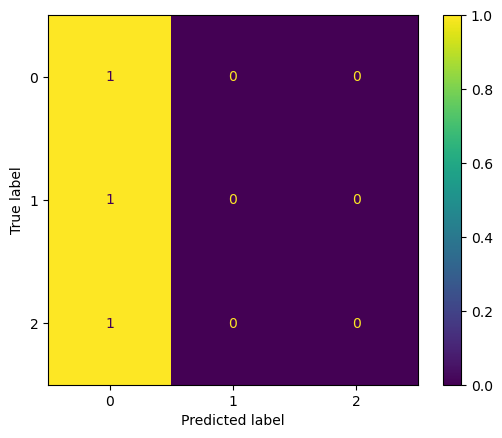

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.39523. Saving Model!
epoch 01, loss: 0.39338, acc: 0.89462, val_loss: 0.39523, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 02, loss: 0.39289, acc: 0.89460, val_loss: 0.39551, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 03, loss: 0.39236, acc: 0.89465, val_loss: 0.39615, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 04, loss: 0.39192, acc: 0.89465, val_loss: 0.39709, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


epoch 05, loss: 0.39147, acc: 0.89465, val_loss: 0.39806, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 06, loss: 0.39106, acc: 0.89465, val_loss: 0.39889, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70it/s]


epoch 07, loss: 0.39071, acc: 0.89465, val_loss: 0.39958, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 08, loss: 0.39045, acc: 0.89465, val_loss: 0.40015, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 09, loss: 0.39020, acc: 0.89465, val_loss: 0.40060, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 10, loss: 0.38995, acc: 0.89465, val_loss: 0.40096, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 11, loss: 0.38970, acc: 0.89468, val_loss: 0.40125, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 12, loss: 0.38948, acc: 0.89468, val_loss: 0.40157, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 13, loss: 0.38925, acc: 0.89468, val_loss: 0.40190, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 14, loss: 0.38900, acc: 0.89468, val_loss: 0.40222, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 15, loss: 0.38875, acc: 0.89468, val_loss: 0.40250, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 16, loss: 0.38849, acc: 0.89468, val_loss: 0.40277, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


epoch 17, loss: 0.38825, acc: 0.89465, val_loss: 0.40304, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 18, loss: 0.38799, acc: 0.89468, val_loss: 0.40331, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 19, loss: 0.38773, acc: 0.89471, val_loss: 0.40355, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 20, loss: 0.38749, acc: 0.89468, val_loss: 0.40378, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 21, loss: 0.38725, acc: 0.89474, val_loss: 0.40399, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 22, loss: 0.38700, acc: 0.89477, val_loss: 0.40420, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 23, loss: 0.38675, acc: 0.89474, val_loss: 0.40442, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 24, loss: 0.38651, acc: 0.89474, val_loss: 0.40461, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 25, loss: 0.38628, acc: 0.89474, val_loss: 0.40477, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 26, loss: 0.38606, acc: 0.89474, val_loss: 0.40490, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24it/s]


epoch 27, loss: 0.38583, acc: 0.89471, val_loss: 0.40501, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 28, loss: 0.38559, acc: 0.89471, val_loss: 0.40511, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 29, loss: 0.38537, acc: 0.89471, val_loss: 0.40519, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 30, loss: 0.38513, acc: 0.89471, val_loss: 0.40527, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 31, loss: 0.38489, acc: 0.89471, val_loss: 0.40534, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 32, loss: 0.38467, acc: 0.89471, val_loss: 0.40543, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 33, loss: 0.38443, acc: 0.89471, val_loss: 0.40552, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 34, loss: 0.38418, acc: 0.89471, val_loss: 0.40561, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 35, loss: 0.38395, acc: 0.89471, val_loss: 0.40567, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


epoch 36, loss: 0.38372, acc: 0.89471, val_loss: 0.40574, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 37, loss: 0.38348, acc: 0.89471, val_loss: 0.40586, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 38, loss: 0.38325, acc: 0.89471, val_loss: 0.40599, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84it/s]


epoch 39, loss: 0.38300, acc: 0.89471, val_loss: 0.40607, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 40, loss: 0.38274, acc: 0.89471, val_loss: 0.40613, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 41, loss: 0.38251, acc: 0.89471, val_loss: 0.40617, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 42, loss: 0.38228, acc: 0.89471, val_loss: 0.40622, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 43, loss: 0.38203, acc: 0.89468, val_loss: 0.40631, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 44, loss: 0.38178, acc: 0.89468, val_loss: 0.40643, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 45, loss: 0.38153, acc: 0.89468, val_loss: 0.40655, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 46, loss: 0.38128, acc: 0.89471, val_loss: 0.40667, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 47, loss: 0.38104, acc: 0.89471, val_loss: 0.40680, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]


epoch 48, loss: 0.38079, acc: 0.89471, val_loss: 0.40693, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 49, loss: 0.38052, acc: 0.89471, val_loss: 0.40703, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 50, loss: 0.38028, acc: 0.89471, val_loss: 0.40711, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 51, loss: 0.38003, acc: 0.89471, val_loss: 0.40722, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 52, loss: 0.37976, acc: 0.89471, val_loss: 0.40735, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 53, loss: 0.37953, acc: 0.89471, val_loss: 0.40744, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 54, loss: 0.37924, acc: 0.89474, val_loss: 0.40752, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 55, loss: 0.37898, acc: 0.89474, val_loss: 0.40761, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 56, loss: 0.37873, acc: 0.89474, val_loss: 0.40771, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 57, loss: 0.37844, acc: 0.89474, val_loss: 0.40785, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94it/s]


epoch 58, loss: 0.37821, acc: 0.89474, val_loss: 0.40797, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 59, loss: 0.37793, acc: 0.89474, val_loss: 0.40805, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 60, loss: 0.37762, acc: 0.89474, val_loss: 0.40815, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 61, loss: 0.37736, acc: 0.89474, val_loss: 0.40827, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 62, loss: 0.37709, acc: 0.89474, val_loss: 0.40838, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 63, loss: 0.37682, acc: 0.89474, val_loss: 0.40844, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 64, loss: 0.37655, acc: 0.89474, val_loss: 0.40847, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 65, loss: 0.37628, acc: 0.89474, val_loss: 0.40862, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24it/s]


epoch 66, loss: 0.37595, acc: 0.89474, val_loss: 0.40879, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 67, loss: 0.37572, acc: 0.89474, val_loss: 0.40891, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 68, loss: 0.37545, acc: 0.89474, val_loss: 0.40908, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 69, loss: 0.37513, acc: 0.89474, val_loss: 0.40922, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 70, loss: 0.37487, acc: 0.89474, val_loss: 0.40932, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 71, loss: 0.37455, acc: 0.89474, val_loss: 0.40945, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 72, loss: 0.37426, acc: 0.89474, val_loss: 0.40966, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.72it/s]


epoch 73, loss: 0.37399, acc: 0.89477, val_loss: 0.40979, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 74, loss: 0.37366, acc: 0.89477, val_loss: 0.40987, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 75, loss: 0.37342, acc: 0.89480, val_loss: 0.40994, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 76, loss: 0.37311, acc: 0.89483, val_loss: 0.41005, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 77, loss: 0.37281, acc: 0.89480, val_loss: 0.41026, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


epoch 78, loss: 0.37251, acc: 0.89480, val_loss: 0.41049, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 79, loss: 0.37219, acc: 0.89474, val_loss: 0.41060, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 80, loss: 0.37190, acc: 0.89477, val_loss: 0.41059, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 81, loss: 0.37162, acc: 0.89477, val_loss: 0.41062, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 82, loss: 0.37132, acc: 0.89477, val_loss: 0.41086, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 83, loss: 0.37096, acc: 0.89480, val_loss: 0.41124, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 84, loss: 0.37067, acc: 0.89480, val_loss: 0.41145, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 85, loss: 0.37033, acc: 0.89480, val_loss: 0.41146, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.93it/s]


epoch 86, loss: 0.37000, acc: 0.89480, val_loss: 0.41162, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 87, loss: 0.36971, acc: 0.89480, val_loss: 0.41199, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 88, loss: 0.36935, acc: 0.89480, val_loss: 0.41219, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 89, loss: 0.36903, acc: 0.89480, val_loss: 0.41230, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 90, loss: 0.36868, acc: 0.89480, val_loss: 0.41249, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 91, loss: 0.36830, acc: 0.89480, val_loss: 0.41275, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 92, loss: 0.36794, acc: 0.89480, val_loss: 0.41299, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 93, loss: 0.36759, acc: 0.89489, val_loss: 0.41324, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 94, loss: 0.36723, acc: 0.89489, val_loss: 0.41343, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 95, loss: 0.36685, acc: 0.89489, val_loss: 0.41355, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 96, loss: 0.36651, acc: 0.89489, val_loss: 0.41379, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 97, loss: 0.36615, acc: 0.89489, val_loss: 0.41403, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 98, loss: 0.36575, acc: 0.89486, val_loss: 0.41447, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 99, loss: 0.36536, acc: 0.89486, val_loss: 0.41487, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 100, loss: 0.36497, acc: 0.89486, val_loss: 0.41503, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 101, loss: 0.36458, acc: 0.89486, val_loss: 0.41562, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 102, loss: 0.36418, acc: 0.89486, val_loss: 0.41625, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 103, loss: 0.36375, acc: 0.89489, val_loss: 0.41639, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 104, loss: 0.36334, acc: 0.89489, val_loss: 0.41678, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 105, loss: 0.36293, acc: 0.89495, val_loss: 0.41739, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 106, loss: 0.36251, acc: 0.89500, val_loss: 0.41763, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 107, loss: 0.36209, acc: 0.89506, val_loss: 0.41827, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


epoch 108, loss: 0.36168, acc: 0.90014, val_loss: 0.41906, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 109, loss: 0.36127, acc: 0.90014, val_loss: 0.41923, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 110, loss: 0.36084, acc: 0.90020, val_loss: 0.41975, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 111, loss: 0.36038, acc: 0.90020, val_loss: 0.42049, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


epoch 112, loss: 0.35990, acc: 0.90029, val_loss: 0.42127, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 113, loss: 0.35949, acc: 0.90044, val_loss: 0.42184, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 114, loss: 0.35903, acc: 0.90055, val_loss: 0.42245, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 115, loss: 0.35855, acc: 0.90055, val_loss: 0.42298, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 116, loss: 0.35811, acc: 0.90058, val_loss: 0.42365, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 117, loss: 0.35766, acc: 0.90070, val_loss: 0.42447, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 118, loss: 0.35719, acc: 0.90070, val_loss: 0.42453, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 119, loss: 0.35676, acc: 0.90081, val_loss: 0.42453, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 120, loss: 0.35635, acc: 0.90067, val_loss: 0.42561, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 121, loss: 0.35588, acc: 0.90067, val_loss: 0.42570, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


epoch 122, loss: 0.35546, acc: 0.90081, val_loss: 0.42669, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 123, loss: 0.35503, acc: 0.90076, val_loss: 0.42727, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 124, loss: 0.35454, acc: 0.90087, val_loss: 0.42720, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 125, loss: 0.35413, acc: 0.90081, val_loss: 0.42840, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 126, loss: 0.35368, acc: 0.90090, val_loss: 0.42803, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68it/s]


epoch 127, loss: 0.35316, acc: 0.90096, val_loss: 0.42901, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 128, loss: 0.35286, acc: 0.90090, val_loss: 0.43024, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01it/s]


epoch 129, loss: 0.35236, acc: 0.90099, val_loss: 0.42922, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


epoch 130, loss: 0.35188, acc: 0.90090, val_loss: 0.43123, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 131, loss: 0.35160, acc: 0.90093, val_loss: 0.43137, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 132, loss: 0.35100, acc: 0.90108, val_loss: 0.43162, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 133, loss: 0.35067, acc: 0.90090, val_loss: 0.43410, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


epoch 134, loss: 0.35034, acc: 0.90111, val_loss: 0.43231, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 135, loss: 0.34974, acc: 0.90108, val_loss: 0.43350, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 136, loss: 0.34946, acc: 0.90111, val_loss: 0.43524, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 137, loss: 0.34900, acc: 0.90111, val_loss: 0.43395, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 138, loss: 0.34852, acc: 0.90111, val_loss: 0.43498, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 139, loss: 0.34831, acc: 0.90119, val_loss: 0.43781, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 140, loss: 0.34794, acc: 0.90119, val_loss: 0.43527, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 141, loss: 0.34745, acc: 0.90114, val_loss: 0.43609, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 142, loss: 0.34734, acc: 0.90108, val_loss: 0.44011, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 143, loss: 0.34704, acc: 0.90099, val_loss: 0.43674, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 144, loss: 0.34653, acc: 0.90125, val_loss: 0.43679, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 145, loss: 0.34659, acc: 0.90119, val_loss: 0.44367, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 146, loss: 0.34628, acc: 0.90111, val_loss: 0.43712, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 147, loss: 0.34545, acc: 0.90114, val_loss: 0.43760, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 148, loss: 0.34586, acc: 0.90128, val_loss: 0.44634, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 149, loss: 0.34525, acc: 0.90140, val_loss: 0.43792, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92it/s]


epoch 150, loss: 0.34435, acc: 0.90131, val_loss: 0.43816, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 151, loss: 0.34485, acc: 0.90044, val_loss: 0.44816, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 152, loss: 0.34435, acc: 0.90119, val_loss: 0.44048, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 153, loss: 0.34323, acc: 0.90137, val_loss: 0.43923, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 154, loss: 0.34407, acc: 0.90023, val_loss: 0.45110, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 155, loss: 0.34334, acc: 0.90143, val_loss: 0.43998, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 156, loss: 0.34188, acc: 0.90128, val_loss: 0.44152, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 157, loss: 0.34248, acc: 0.90049, val_loss: 0.44792, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 158, loss: 0.34215, acc: 0.90122, val_loss: 0.44378, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 159, loss: 0.34137, acc: 0.90128, val_loss: 0.44120, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 160, loss: 0.34216, acc: 0.90041, val_loss: 0.44869, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 161, loss: 0.34160, acc: 0.90154, val_loss: 0.44435, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


epoch 162, loss: 0.33969, acc: 0.90149, val_loss: 0.44584, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 163, loss: 0.33991, acc: 0.90017, val_loss: 0.44616, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 164, loss: 0.34004, acc: 0.90032, val_loss: 0.45053, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 165, loss: 0.33897, acc: 0.90149, val_loss: 0.44207, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 166, loss: 0.33930, acc: 0.90008, val_loss: 0.45564, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


epoch 167, loss: 0.33904, acc: 0.90160, val_loss: 0.44372, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 168, loss: 0.33772, acc: 0.90046, val_loss: 0.44577, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 169, loss: 0.33809, acc: 0.90061, val_loss: 0.44976, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 170, loss: 0.33760, acc: 0.90134, val_loss: 0.45148, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 171, loss: 0.33702, acc: 0.90140, val_loss: 0.44581, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70it/s]


epoch 172, loss: 0.33708, acc: 0.90049, val_loss: 0.45000, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 173, loss: 0.33671, acc: 0.90143, val_loss: 0.45013, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s]


epoch 174, loss: 0.33586, acc: 0.90143, val_loss: 0.45254, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 175, loss: 0.33562, acc: 0.90157, val_loss: 0.44562, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 176, loss: 0.33549, acc: 0.90046, val_loss: 0.45134, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 177, loss: 0.33545, acc: 0.90067, val_loss: 0.45096, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


epoch 178, loss: 0.33504, acc: 0.90125, val_loss: 0.45617, val_accuracy: 0.89333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 179, loss: 0.33444, acc: 0.90163, val_loss: 0.44686, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 180, loss: 0.33440, acc: 0.90049, val_loss: 0.45483, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 181, loss: 0.33413, acc: 0.90090, val_loss: 0.45196, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 182, loss: 0.33360, acc: 0.90152, val_loss: 0.45995, val_accuracy: 0.89333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 183, loss: 0.33322, acc: 0.90184, val_loss: 0.44793, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 184, loss: 0.33301, acc: 0.90076, val_loss: 0.45413, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.26it/s]


epoch 185, loss: 0.33290, acc: 0.90081, val_loss: 0.45325, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 186, loss: 0.33241, acc: 0.90160, val_loss: 0.46125, val_accuracy: 0.89280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 187, loss: 0.33205, acc: 0.90189, val_loss: 0.45215, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


epoch 188, loss: 0.33170, acc: 0.90096, val_loss: 0.45323, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 189, loss: 0.33191, acc: 0.90093, val_loss: 0.45268, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 190, loss: 0.33211, acc: 0.90143, val_loss: 0.47164, val_accuracy: 0.89254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 191, loss: 0.33241, acc: 0.90216, val_loss: 0.45221, val_accuracy: 0.89333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 192, loss: 0.33121, acc: 0.90114, val_loss: 0.45267, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 193, loss: 0.33229, acc: 0.90125, val_loss: 0.45090, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 194, loss: 0.33285, acc: 0.90140, val_loss: 0.48719, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 195, loss: 0.33453, acc: 0.90254, val_loss: 0.45163, val_accuracy: 0.89306


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 196, loss: 0.33182, acc: 0.90119, val_loss: 0.45219, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 197, loss: 0.33287, acc: 0.90093, val_loss: 0.45735, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


epoch 198, loss: 0.33277, acc: 0.90134, val_loss: 0.49128, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 199, loss: 0.33496, acc: 0.90268, val_loss: 0.45233, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 200, loss: 0.33174, acc: 0.90114, val_loss: 0.45189, val_accuracy: 0.89359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 201, loss: 0.33308, acc: 0.90058, val_loss: 0.47276, val_accuracy: 0.89280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 202, loss: 0.33137, acc: 0.90227, val_loss: 0.47713, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 203, loss: 0.33093, acc: 0.90321, val_loss: 0.45123, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 204, loss: 0.33086, acc: 0.90079, val_loss: 0.45773, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 205, loss: 0.33225, acc: 0.90084, val_loss: 0.49107, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 206, loss: 0.33012, acc: 0.90260, val_loss: 0.45294, val_accuracy: 0.89280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 207, loss: 0.32913, acc: 0.90271, val_loss: 0.45599, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 208, loss: 0.32932, acc: 0.90081, val_loss: 0.47202, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 209, loss: 0.32833, acc: 0.90227, val_loss: 0.47524, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 210, loss: 0.32795, acc: 0.90330, val_loss: 0.45277, val_accuracy: 0.89359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 211, loss: 0.32703, acc: 0.90239, val_loss: 0.45733, val_accuracy: 0.89385


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 212, loss: 0.32893, acc: 0.90093, val_loss: 0.47998, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.72it/s]


epoch 213, loss: 0.32728, acc: 0.90242, val_loss: 0.47214, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 214, loss: 0.32672, acc: 0.90359, val_loss: 0.45412, val_accuracy: 0.89359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 215, loss: 0.32739, acc: 0.90131, val_loss: 0.46324, val_accuracy: 0.89359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


epoch 216, loss: 0.32862, acc: 0.90225, val_loss: 0.48769, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 217, loss: 0.32652, acc: 0.90245, val_loss: 0.46147, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 218, loss: 0.32569, acc: 0.90251, val_loss: 0.45698, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 219, loss: 0.32725, acc: 0.90111, val_loss: 0.46836, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 220, loss: 0.32708, acc: 0.90233, val_loss: 0.48740, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 221, loss: 0.32530, acc: 0.90341, val_loss: 0.45849, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 222, loss: 0.32462, acc: 0.90330, val_loss: 0.45784, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87it/s]


epoch 223, loss: 0.32722, acc: 0.90076, val_loss: 0.49027, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 224, loss: 0.32571, acc: 0.90292, val_loss: 0.46966, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 225, loss: 0.32395, acc: 0.90382, val_loss: 0.46011, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 226, loss: 0.32417, acc: 0.90213, val_loss: 0.46218, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 227, loss: 0.32695, acc: 0.90239, val_loss: 0.51372, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 228, loss: 0.32691, acc: 0.90321, val_loss: 0.45209, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 229, loss: 0.32528, acc: 0.90283, val_loss: 0.46197, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 230, loss: 0.32556, acc: 0.90169, val_loss: 0.47218, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 231, loss: 0.32430, acc: 0.90251, val_loss: 0.50642, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


epoch 232, loss: 0.32575, acc: 0.90438, val_loss: 0.45677, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 233, loss: 0.32447, acc: 0.90283, val_loss: 0.46276, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.54it/s]


epoch 234, loss: 0.32477, acc: 0.90181, val_loss: 0.49604, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 235, loss: 0.32204, acc: 0.90318, val_loss: 0.47480, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 236, loss: 0.32145, acc: 0.90423, val_loss: 0.46219, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 237, loss: 0.32240, acc: 0.90233, val_loss: 0.47308, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 238, loss: 0.32290, acc: 0.90254, val_loss: 0.51017, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 239, loss: 0.32188, acc: 0.90452, val_loss: 0.46089, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 240, loss: 0.32139, acc: 0.90309, val_loss: 0.46631, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 241, loss: 0.32220, acc: 0.90213, val_loss: 0.48719, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 242, loss: 0.32071, acc: 0.90283, val_loss: 0.49862, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 243, loss: 0.32099, acc: 0.90449, val_loss: 0.46085, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 244, loss: 0.32138, acc: 0.90306, val_loss: 0.47023, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 245, loss: 0.32158, acc: 0.90260, val_loss: 0.49218, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 246, loss: 0.31880, acc: 0.90341, val_loss: 0.48857, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 247, loss: 0.31844, acc: 0.90490, val_loss: 0.46417, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 248, loss: 0.31984, acc: 0.90309, val_loss: 0.47604, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 249, loss: 0.31948, acc: 0.90303, val_loss: 0.49215, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 250, loss: 0.31704, acc: 0.90476, val_loss: 0.48188, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 251, loss: 0.31628, acc: 0.90505, val_loss: 0.46608, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 252, loss: 0.31832, acc: 0.90309, val_loss: 0.47755, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 253, loss: 0.31812, acc: 0.90306, val_loss: 0.49355, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 254, loss: 0.31634, acc: 0.90543, val_loss: 0.48342, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 255, loss: 0.31539, acc: 0.90531, val_loss: 0.46580, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 256, loss: 0.31858, acc: 0.90286, val_loss: 0.47602, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 257, loss: 0.31769, acc: 0.90327, val_loss: 0.49490, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 258, loss: 0.31615, acc: 0.90525, val_loss: 0.49368, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 259, loss: 0.31539, acc: 0.90502, val_loss: 0.46305, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 260, loss: 0.31896, acc: 0.90283, val_loss: 0.47445, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 261, loss: 0.31898, acc: 0.90315, val_loss: 0.49939, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 262, loss: 0.31710, acc: 0.90499, val_loss: 0.50294, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 263, loss: 0.31628, acc: 0.90519, val_loss: 0.46576, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 264, loss: 0.32005, acc: 0.90260, val_loss: 0.46927, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 265, loss: 0.32032, acc: 0.90335, val_loss: 0.50284, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 266, loss: 0.31946, acc: 0.90432, val_loss: 0.51246, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 267, loss: 0.32003, acc: 0.90467, val_loss: 0.46953, val_accuracy: 0.87204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 268, loss: 0.32315, acc: 0.90254, val_loss: 0.46810, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 269, loss: 0.31981, acc: 0.90315, val_loss: 0.52965, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 270, loss: 0.31842, acc: 0.90496, val_loss: 0.47282, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 271, loss: 0.31687, acc: 0.90417, val_loss: 0.47855, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 272, loss: 0.31906, acc: 0.90283, val_loss: 0.48679, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 273, loss: 0.31483, acc: 0.90441, val_loss: 0.51976, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


epoch 274, loss: 0.31428, acc: 0.90566, val_loss: 0.46889, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 275, loss: 0.31406, acc: 0.90411, val_loss: 0.47674, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 276, loss: 0.31540, acc: 0.90379, val_loss: 0.49515, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 277, loss: 0.31312, acc: 0.90519, val_loss: 0.51481, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 278, loss: 0.31303, acc: 0.90598, val_loss: 0.46777, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.40it/s]


epoch 279, loss: 0.31461, acc: 0.90429, val_loss: 0.47845, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 280, loss: 0.31432, acc: 0.90417, val_loss: 0.49703, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 281, loss: 0.31201, acc: 0.90552, val_loss: 0.50660, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 282, loss: 0.31173, acc: 0.90607, val_loss: 0.46968, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 283, loss: 0.31375, acc: 0.90397, val_loss: 0.47704, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 284, loss: 0.31319, acc: 0.90435, val_loss: 0.49814, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 285, loss: 0.31163, acc: 0.90525, val_loss: 0.50668, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


epoch 286, loss: 0.31147, acc: 0.90592, val_loss: 0.47043, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 287, loss: 0.31416, acc: 0.90382, val_loss: 0.47467, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 288, loss: 0.31364, acc: 0.90414, val_loss: 0.50592, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 289, loss: 0.31172, acc: 0.90560, val_loss: 0.50149, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39it/s]


epoch 290, loss: 0.31104, acc: 0.90613, val_loss: 0.47353, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 291, loss: 0.31438, acc: 0.90411, val_loss: 0.46996, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 292, loss: 0.31382, acc: 0.90406, val_loss: 0.51195, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 293, loss: 0.31270, acc: 0.90546, val_loss: 0.50390, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 294, loss: 0.31204, acc: 0.90557, val_loss: 0.47444, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


epoch 295, loss: 0.31685, acc: 0.90327, val_loss: 0.47204, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 296, loss: 0.31393, acc: 0.90411, val_loss: 0.52659, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 297, loss: 0.31261, acc: 0.90572, val_loss: 0.48858, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 298, loss: 0.31147, acc: 0.90531, val_loss: 0.47744, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 299, loss: 0.31556, acc: 0.90365, val_loss: 0.48334, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 300, loss: 0.31124, acc: 0.90458, val_loss: 0.53087, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 301, loss: 0.31042, acc: 0.90642, val_loss: 0.47647, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 302, loss: 0.30962, acc: 0.90496, val_loss: 0.47768, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 303, loss: 0.31211, acc: 0.90479, val_loss: 0.50440, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 304, loss: 0.30906, acc: 0.90566, val_loss: 0.51470, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 305, loss: 0.30807, acc: 0.90665, val_loss: 0.47529, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 306, loss: 0.30930, acc: 0.90476, val_loss: 0.47981, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


epoch 307, loss: 0.30970, acc: 0.90481, val_loss: 0.50764, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 308, loss: 0.30806, acc: 0.90584, val_loss: 0.51583, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 309, loss: 0.30785, acc: 0.90671, val_loss: 0.47428, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 310, loss: 0.31050, acc: 0.90420, val_loss: 0.48438, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 311, loss: 0.30883, acc: 0.90487, val_loss: 0.50767, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 312, loss: 0.30710, acc: 0.90572, val_loss: 0.51334, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 313, loss: 0.30730, acc: 0.90686, val_loss: 0.47653, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 314, loss: 0.31050, acc: 0.90376, val_loss: 0.47957, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 315, loss: 0.30984, acc: 0.90473, val_loss: 0.52609, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 316, loss: 0.30849, acc: 0.90575, val_loss: 0.50103, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 317, loss: 0.30763, acc: 0.90572, val_loss: 0.47974, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


epoch 318, loss: 0.31095, acc: 0.90397, val_loss: 0.48898, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 319, loss: 0.30747, acc: 0.90519, val_loss: 0.51808, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 320, loss: 0.30586, acc: 0.90595, val_loss: 0.50549, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 321, loss: 0.30509, acc: 0.90613, val_loss: 0.47704, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


epoch 322, loss: 0.30982, acc: 0.90400, val_loss: 0.49334, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 323, loss: 0.30757, acc: 0.90537, val_loss: 0.52727, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 324, loss: 0.30571, acc: 0.90651, val_loss: 0.49236, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.28it/s]


epoch 325, loss: 0.30464, acc: 0.90689, val_loss: 0.47964, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 326, loss: 0.30805, acc: 0.90534, val_loss: 0.50396, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 327, loss: 0.30488, acc: 0.90581, val_loss: 0.51536, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85it/s]


epoch 328, loss: 0.30317, acc: 0.90706, val_loss: 0.49644, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 329, loss: 0.30232, acc: 0.90674, val_loss: 0.48049, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.61it/s]


epoch 330, loss: 0.30531, acc: 0.90566, val_loss: 0.49769, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 331, loss: 0.30390, acc: 0.90592, val_loss: 0.52343, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 332, loss: 0.30473, acc: 0.90660, val_loss: 0.50358, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 333, loss: 0.30411, acc: 0.90601, val_loss: 0.47780, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 334, loss: 0.30882, acc: 0.90426, val_loss: 0.49137, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 335, loss: 0.30891, acc: 0.90490, val_loss: 0.56129, val_accuracy: 0.85970


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 336, loss: 0.31141, acc: 0.90537, val_loss: 0.49153, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 337, loss: 0.31140, acc: 0.90552, val_loss: 0.48366, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 338, loss: 0.31506, acc: 0.90335, val_loss: 0.49481, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 339, loss: 0.31413, acc: 0.90449, val_loss: 0.59510, val_accuracy: 0.77036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 340, loss: 0.31483, acc: 0.90432, val_loss: 0.48180, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 341, loss: 0.31538, acc: 0.90265, val_loss: 0.48723, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 342, loss: 0.31180, acc: 0.90432, val_loss: 0.56498, val_accuracy: 0.82738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 343, loss: 0.30917, acc: 0.90566, val_loss: 0.49016, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 344, loss: 0.30831, acc: 0.90700, val_loss: 0.48577, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 345, loss: 0.30924, acc: 0.90537, val_loss: 0.52817, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 346, loss: 0.30395, acc: 0.90590, val_loss: 0.52333, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 347, loss: 0.30507, acc: 0.90721, val_loss: 0.48956, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 348, loss: 0.30973, acc: 0.90484, val_loss: 0.49327, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 349, loss: 0.30852, acc: 0.90607, val_loss: 0.54927, val_accuracy: 0.82554


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 350, loss: 0.30795, acc: 0.90654, val_loss: 0.49360, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 351, loss: 0.30571, acc: 0.90741, val_loss: 0.48326, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 352, loss: 0.30702, acc: 0.90613, val_loss: 0.51888, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 353, loss: 0.30318, acc: 0.90665, val_loss: 0.51564, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 354, loss: 0.30072, acc: 0.90744, val_loss: 0.48990, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


epoch 355, loss: 0.30016, acc: 0.90695, val_loss: 0.49567, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.09it/s]


epoch 356, loss: 0.29843, acc: 0.90680, val_loss: 0.51859, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 357, loss: 0.29808, acc: 0.90636, val_loss: 0.51309, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 358, loss: 0.29691, acc: 0.90741, val_loss: 0.48723, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 359, loss: 0.29985, acc: 0.90622, val_loss: 0.50128, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 360, loss: 0.29841, acc: 0.90654, val_loss: 0.52384, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 361, loss: 0.29705, acc: 0.90657, val_loss: 0.51814, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 362, loss: 0.29657, acc: 0.90765, val_loss: 0.48524, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 363, loss: 0.30019, acc: 0.90639, val_loss: 0.50116, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 364, loss: 0.29850, acc: 0.90642, val_loss: 0.52284, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 365, loss: 0.29703, acc: 0.90712, val_loss: 0.53107, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]


epoch 366, loss: 0.29648, acc: 0.90808, val_loss: 0.48512, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


epoch 367, loss: 0.30094, acc: 0.90665, val_loss: 0.49856, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 368, loss: 0.29962, acc: 0.90645, val_loss: 0.52555, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 369, loss: 0.29811, acc: 0.90721, val_loss: 0.55100, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 370, loss: 0.29839, acc: 0.90771, val_loss: 0.48703, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 371, loss: 0.30301, acc: 0.90569, val_loss: 0.48972, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 372, loss: 0.30224, acc: 0.90633, val_loss: 0.52831, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 373, loss: 0.30184, acc: 0.90706, val_loss: 0.56359, val_accuracy: 0.81503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s]


epoch 374, loss: 0.30303, acc: 0.90636, val_loss: 0.49267, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 375, loss: 0.30742, acc: 0.90321, val_loss: 0.48682, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 376, loss: 0.30277, acc: 0.90587, val_loss: 0.55789, val_accuracy: 0.82738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 377, loss: 0.30339, acc: 0.90642, val_loss: 0.52352, val_accuracy: 0.85864


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 378, loss: 0.30174, acc: 0.90633, val_loss: 0.50346, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 379, loss: 0.30702, acc: 0.90426, val_loss: 0.49245, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 380, loss: 0.30028, acc: 0.90654, val_loss: 0.59505, val_accuracy: 0.78245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 381, loss: 0.30226, acc: 0.90651, val_loss: 0.49266, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 382, loss: 0.30020, acc: 0.90645, val_loss: 0.49950, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


epoch 383, loss: 0.30241, acc: 0.90651, val_loss: 0.51945, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 384, loss: 0.29673, acc: 0.90703, val_loss: 0.56809, val_accuracy: 0.78245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 385, loss: 0.29756, acc: 0.90759, val_loss: 0.49248, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 386, loss: 0.29749, acc: 0.90779, val_loss: 0.49986, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 387, loss: 0.29603, acc: 0.90744, val_loss: 0.52923, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 388, loss: 0.29366, acc: 0.90776, val_loss: 0.53567, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 389, loss: 0.29276, acc: 0.90841, val_loss: 0.50106, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 390, loss: 0.29457, acc: 0.90814, val_loss: 0.50651, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


epoch 391, loss: 0.29394, acc: 0.90782, val_loss: 0.54008, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 392, loss: 0.29311, acc: 0.90803, val_loss: 0.53282, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 393, loss: 0.29187, acc: 0.90841, val_loss: 0.50175, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


epoch 394, loss: 0.29501, acc: 0.90800, val_loss: 0.50531, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 395, loss: 0.29456, acc: 0.90771, val_loss: 0.54636, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 396, loss: 0.29377, acc: 0.90782, val_loss: 0.53779, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 397, loss: 0.29303, acc: 0.90788, val_loss: 0.49944, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 398, loss: 0.29781, acc: 0.90665, val_loss: 0.50042, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 399, loss: 0.29674, acc: 0.90692, val_loss: 0.55625, val_accuracy: 0.82580


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 400, loss: 0.29739, acc: 0.90683, val_loss: 0.54574, val_accuracy: 0.85864


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 401, loss: 0.29676, acc: 0.90733, val_loss: 0.50201, val_accuracy: 0.87204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 402, loss: 0.30371, acc: 0.90525, val_loss: 0.50382, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 403, loss: 0.29789, acc: 0.90680, val_loss: 0.57646, val_accuracy: 0.82606


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 404, loss: 0.29859, acc: 0.90683, val_loss: 0.53054, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 405, loss: 0.29698, acc: 0.90721, val_loss: 0.50403, val_accuracy: 0.87204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 406, loss: 0.30384, acc: 0.90549, val_loss: 0.51391, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 407, loss: 0.29552, acc: 0.90695, val_loss: 0.58477, val_accuracy: 0.78297


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 408, loss: 0.29590, acc: 0.90689, val_loss: 0.51177, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


epoch 409, loss: 0.29458, acc: 0.90762, val_loss: 0.50611, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.52it/s]


epoch 410, loss: 0.29758, acc: 0.90677, val_loss: 0.52957, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


epoch 411, loss: 0.29382, acc: 0.90753, val_loss: 0.57991, val_accuracy: 0.77036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 412, loss: 0.29394, acc: 0.90642, val_loss: 0.50653, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 413, loss: 0.29532, acc: 0.90750, val_loss: 0.51377, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


epoch 414, loss: 0.29284, acc: 0.90806, val_loss: 0.54022, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 415, loss: 0.29068, acc: 0.90823, val_loss: 0.55443, val_accuracy: 0.85996


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 416, loss: 0.28971, acc: 0.90887, val_loss: 0.51079, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 417, loss: 0.29206, acc: 0.90829, val_loss: 0.51192, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 418, loss: 0.29113, acc: 0.90829, val_loss: 0.54889, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 419, loss: 0.29063, acc: 0.90806, val_loss: 0.55156, val_accuracy: 0.86994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 420, loss: 0.28955, acc: 0.90852, val_loss: 0.51159, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 421, loss: 0.29369, acc: 0.90765, val_loss: 0.51044, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


epoch 422, loss: 0.29246, acc: 0.90773, val_loss: 0.56625, val_accuracy: 0.82606


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 423, loss: 0.29304, acc: 0.90768, val_loss: 0.54745, val_accuracy: 0.85838


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 424, loss: 0.29201, acc: 0.90756, val_loss: 0.51027, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 425, loss: 0.29802, acc: 0.90627, val_loss: 0.51281, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 426, loss: 0.29344, acc: 0.90738, val_loss: 0.58238, val_accuracy: 0.78271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 427, loss: 0.29467, acc: 0.90782, val_loss: 0.53727, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 428, loss: 0.29308, acc: 0.90803, val_loss: 0.51242, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 429, loss: 0.30051, acc: 0.90616, val_loss: 0.52386, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.50it/s]


epoch 430, loss: 0.29353, acc: 0.90712, val_loss: 0.60191, val_accuracy: 0.77036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 431, loss: 0.29381, acc: 0.90715, val_loss: 0.51828, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 432, loss: 0.29313, acc: 0.90753, val_loss: 0.51270, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 433, loss: 0.29520, acc: 0.90692, val_loss: 0.54331, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 434, loss: 0.29162, acc: 0.90747, val_loss: 0.59016, val_accuracy: 0.77063


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 435, loss: 0.29156, acc: 0.90671, val_loss: 0.51565, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 436, loss: 0.29325, acc: 0.90811, val_loss: 0.52106, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


epoch 437, loss: 0.28954, acc: 0.90808, val_loss: 0.55400, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 438, loss: 0.28788, acc: 0.90867, val_loss: 0.55765, val_accuracy: 0.85812


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 439, loss: 0.28645, acc: 0.90934, val_loss: 0.52096, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92it/s]


epoch 440, loss: 0.28907, acc: 0.90861, val_loss: 0.52013, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 441, loss: 0.28798, acc: 0.90835, val_loss: 0.56580, val_accuracy: 0.82580


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 442, loss: 0.28796, acc: 0.90873, val_loss: 0.54684, val_accuracy: 0.86994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 443, loss: 0.28635, acc: 0.90914, val_loss: 0.52064, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 444, loss: 0.29025, acc: 0.90829, val_loss: 0.52248, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 445, loss: 0.28891, acc: 0.90811, val_loss: 0.59121, val_accuracy: 0.77036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 446, loss: 0.29068, acc: 0.90835, val_loss: 0.53663, val_accuracy: 0.86994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 447, loss: 0.28914, acc: 0.90925, val_loss: 0.51906, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 448, loss: 0.29401, acc: 0.90715, val_loss: 0.52253, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 449, loss: 0.29205, acc: 0.90747, val_loss: 0.62900, val_accuracy: 0.76852


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 450, loss: 0.29788, acc: 0.90645, val_loss: 0.52060, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 451, loss: 0.29629, acc: 0.90633, val_loss: 0.51980, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 452, loss: 0.29822, acc: 0.90680, val_loss: 0.54713, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 453, loss: 0.29149, acc: 0.90733, val_loss: 0.62093, val_accuracy: 0.76957


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 454, loss: 0.29144, acc: 0.90765, val_loss: 0.52131, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 455, loss: 0.29152, acc: 0.90808, val_loss: 0.52556, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 456, loss: 0.28830, acc: 0.90803, val_loss: 0.57095, val_accuracy: 0.78140


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 457, loss: 0.28551, acc: 0.90911, val_loss: 0.55650, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01it/s]


epoch 458, loss: 0.28352, acc: 0.91025, val_loss: 0.53178, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 459, loss: 0.28483, acc: 0.90919, val_loss: 0.53458, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 460, loss: 0.28388, acc: 0.90861, val_loss: 0.57106, val_accuracy: 0.82659


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 461, loss: 0.28361, acc: 0.90969, val_loss: 0.54606, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 462, loss: 0.28230, acc: 0.91016, val_loss: 0.52886, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 463, loss: 0.28439, acc: 0.90943, val_loss: 0.53398, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 464, loss: 0.28451, acc: 0.90817, val_loss: 0.59428, val_accuracy: 0.77063


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 465, loss: 0.28642, acc: 0.90911, val_loss: 0.53969, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 466, loss: 0.28528, acc: 0.90981, val_loss: 0.52736, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 467, loss: 0.28838, acc: 0.90858, val_loss: 0.52988, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.57it/s]


epoch 468, loss: 0.28881, acc: 0.90794, val_loss: 0.64308, val_accuracy: 0.76852


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 469, loss: 0.29703, acc: 0.90689, val_loss: 0.53019, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 470, loss: 0.29442, acc: 0.90771, val_loss: 0.52555, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 471, loss: 0.29730, acc: 0.90657, val_loss: 0.54583, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 472, loss: 0.29004, acc: 0.90735, val_loss: 0.64224, val_accuracy: 0.76905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 473, loss: 0.29151, acc: 0.90750, val_loss: 0.53324, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 474, loss: 0.29045, acc: 0.90823, val_loss: 0.52762, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 475, loss: 0.28857, acc: 0.90817, val_loss: 0.57974, val_accuracy: 0.78192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 476, loss: 0.28474, acc: 0.90899, val_loss: 0.57764, val_accuracy: 0.82712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 477, loss: 0.28194, acc: 0.91036, val_loss: 0.53769, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 478, loss: 0.28379, acc: 0.90922, val_loss: 0.54388, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 479, loss: 0.28153, acc: 0.90896, val_loss: 0.57281, val_accuracy: 0.78166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 480, loss: 0.28077, acc: 0.91004, val_loss: 0.55996, val_accuracy: 0.82738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 481, loss: 0.27943, acc: 0.91013, val_loss: 0.53493, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 482, loss: 0.28219, acc: 0.90972, val_loss: 0.54659, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 483, loss: 0.28103, acc: 0.90887, val_loss: 0.58636, val_accuracy: 0.77115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 484, loss: 0.28126, acc: 0.91027, val_loss: 0.55734, val_accuracy: 0.82712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 485, loss: 0.28028, acc: 0.91045, val_loss: 0.53057, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 486, loss: 0.28368, acc: 0.90954, val_loss: 0.54083, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 487, loss: 0.28308, acc: 0.90858, val_loss: 0.61920, val_accuracy: 0.76931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 488, loss: 0.28633, acc: 0.90908, val_loss: 0.55607, val_accuracy: 0.82633


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


epoch 489, loss: 0.28518, acc: 0.90908, val_loss: 0.52983, val_accuracy: 0.87152


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 490, loss: 0.29100, acc: 0.90817, val_loss: 0.53548, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 491, loss: 0.29074, acc: 0.90756, val_loss: 0.68291, val_accuracy: 0.72832


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 492, loss: 0.30276, acc: 0.90566, val_loss: 0.53834, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 493, loss: 0.29850, acc: 0.90549, val_loss: 0.53227, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 494, loss: 0.29805, acc: 0.90654, val_loss: 0.56899, val_accuracy: 0.78192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 495, loss: 0.28767, acc: 0.90858, val_loss: 0.62576, val_accuracy: 0.76984


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 496, loss: 0.28421, acc: 0.91027, val_loss: 0.54098, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 497, loss: 0.28507, acc: 0.90937, val_loss: 0.55743, val_accuracy: 0.82738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 498, loss: 0.28051, acc: 0.90952, val_loss: 0.58036, val_accuracy: 0.78324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 499, loss: 0.27839, acc: 0.91033, val_loss: 0.55131, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 500, loss: 0.27829, acc: 0.90978, val_loss: 0.56157, val_accuracy: 0.82764
1번째 교차검증
evaluation loss: 0.39523, evaluation accuracy: 0.89411
(5, 3806)
(3806, 5)
Learning rate set to 0.085251
0:	learn: 0.9833902	total: 7.05ms	remaining: 7.04s
1:	learn: 0.8933216	total: 14.5ms	remaining: 7.23s
2:	learn: 0.8204484	total: 20.5ms	remaining: 6.81s
3:	learn: 0.7605243	total: 29.7ms	remaining: 7.4s
4:	learn: 0.7105410	total: 35.9ms	remaining: 7.15s
5:	learn: 0.6684026	total: 41.6ms	remaining: 6.89s
6:	learn: 0.6325864	total: 49.3ms	remaining: 6.99s
7:	learn: 0.6019493	total: 55.4ms	remaining: 6.87s
8:	learn: 0.5756119	total: 62.6ms	remaining: 6.89s
9:	learn: 0.5528818	total: 68.7ms	remaining: 6.8s
10:	learn: 0.5332756	total: 75ms	remaining: 6.75s
11:	learn: 0.5162583	total: 82ms	remaining: 6.75s
12:	learn: 0.5013983	total: 90ms	remaining: 6.83s
13:	learn: 0.4884606	total: 96.8ms	remaining: 6.81s
14:	learn: 0.4772405	total: 104ms	remaining: 6.83s
15:	learn: 0.4674530	total: 112ms	remaining:

181:	learn: 0.3998114	total: 1.02s	remaining: 4.61s
182:	learn: 0.3998106	total: 1.03s	remaining: 4.61s
183:	learn: 0.3998098	total: 1.04s	remaining: 4.61s
184:	learn: 0.3998091	total: 1.04s	remaining: 4.6s
185:	learn: 0.3998083	total: 1.05s	remaining: 4.6s
186:	learn: 0.3998075	total: 1.06s	remaining: 4.6s
187:	learn: 0.3998068	total: 1.06s	remaining: 4.59s
188:	learn: 0.3998061	total: 1.07s	remaining: 4.59s
189:	learn: 0.3998054	total: 1.08s	remaining: 4.59s
190:	learn: 0.3998048	total: 1.08s	remaining: 4.59s
191:	learn: 0.3998041	total: 1.09s	remaining: 4.58s
192:	learn: 0.3998034	total: 1.09s	remaining: 4.58s
193:	learn: 0.3998027	total: 1.1s	remaining: 4.58s
194:	learn: 0.3998021	total: 1.11s	remaining: 4.57s
195:	learn: 0.3998015	total: 1.11s	remaining: 4.57s
196:	learn: 0.3998009	total: 1.12s	remaining: 4.56s
197:	learn: 0.3998002	total: 1.13s	remaining: 4.56s
198:	learn: 0.3997996	total: 1.13s	remaining: 4.56s
199:	learn: 0.3997990	total: 1.14s	remaining: 4.55s
200:	learn: 0.39

361:	learn: 0.3997502	total: 2.26s	remaining: 3.98s
362:	learn: 0.3997500	total: 2.27s	remaining: 3.98s
363:	learn: 0.3997499	total: 2.27s	remaining: 3.97s
364:	learn: 0.3997498	total: 2.28s	remaining: 3.97s
365:	learn: 0.3997496	total: 2.29s	remaining: 3.96s
366:	learn: 0.3997495	total: 2.3s	remaining: 3.96s
367:	learn: 0.3997493	total: 2.31s	remaining: 3.96s
368:	learn: 0.3997492	total: 2.31s	remaining: 3.95s
369:	learn: 0.3997490	total: 2.32s	remaining: 3.95s
370:	learn: 0.3997489	total: 2.32s	remaining: 3.94s
371:	learn: 0.3997488	total: 2.33s	remaining: 3.93s
372:	learn: 0.3997486	total: 2.34s	remaining: 3.93s
373:	learn: 0.3997485	total: 2.35s	remaining: 3.93s
374:	learn: 0.3997483	total: 2.35s	remaining: 3.92s
375:	learn: 0.3997482	total: 2.36s	remaining: 3.92s
376:	learn: 0.3997481	total: 2.37s	remaining: 3.91s
377:	learn: 0.3997479	total: 2.37s	remaining: 3.9s
378:	learn: 0.3997478	total: 2.38s	remaining: 3.9s
379:	learn: 0.3997477	total: 2.39s	remaining: 3.89s
380:	learn: 0.3

544:	learn: 0.3997334	total: 3.68s	remaining: 3.07s
545:	learn: 0.3997334	total: 3.69s	remaining: 3.07s
546:	learn: 0.3997334	total: 3.7s	remaining: 3.06s
547:	learn: 0.3997333	total: 3.7s	remaining: 3.06s
548:	learn: 0.3997332	total: 3.71s	remaining: 3.05s
549:	learn: 0.3997332	total: 3.72s	remaining: 3.04s
550:	learn: 0.3997331	total: 3.73s	remaining: 3.04s
551:	learn: 0.3997331	total: 3.74s	remaining: 3.03s
552:	learn: 0.3997330	total: 3.75s	remaining: 3.03s
553:	learn: 0.3997329	total: 3.75s	remaining: 3.02s
554:	learn: 0.3997329	total: 3.76s	remaining: 3.02s
555:	learn: 0.3997328	total: 3.77s	remaining: 3.01s
556:	learn: 0.3997328	total: 3.78s	remaining: 3s
557:	learn: 0.3997327	total: 3.79s	remaining: 3s
558:	learn: 0.3997327	total: 3.8s	remaining: 3s
559:	learn: 0.3997326	total: 3.8s	remaining: 2.99s
560:	learn: 0.3997325	total: 3.81s	remaining: 2.98s
561:	learn: 0.3997325	total: 3.82s	remaining: 2.98s
562:	learn: 0.3997324	total: 3.83s	remaining: 2.97s
563:	learn: 0.3997324	tot

710:	learn: 0.3997264	total: 5.11s	remaining: 2.08s
711:	learn: 0.3997264	total: 5.11s	remaining: 2.07s
712:	learn: 0.3997263	total: 5.12s	remaining: 2.06s
713:	learn: 0.3997263	total: 5.13s	remaining: 2.05s
714:	learn: 0.3997263	total: 5.14s	remaining: 2.05s
715:	learn: 0.3997262	total: 5.15s	remaining: 2.04s
716:	learn: 0.3997262	total: 5.15s	remaining: 2.03s
717:	learn: 0.3997262	total: 5.16s	remaining: 2.03s
718:	learn: 0.3997261	total: 5.17s	remaining: 2.02s
719:	learn: 0.3997261	total: 5.17s	remaining: 2.01s
720:	learn: 0.3997261	total: 5.18s	remaining: 2s
721:	learn: 0.3997260	total: 5.19s	remaining: 2s
722:	learn: 0.3997260	total: 5.2s	remaining: 1.99s
723:	learn: 0.3997259	total: 5.21s	remaining: 1.98s
724:	learn: 0.3997260	total: 5.21s	remaining: 1.98s
725:	learn: 0.3997259	total: 5.22s	remaining: 1.97s
726:	learn: 0.3997259	total: 5.23s	remaining: 1.96s
727:	learn: 0.3997258	total: 5.24s	remaining: 1.96s
728:	learn: 0.3997258	total: 5.24s	remaining: 1.95s
729:	learn: 0.39972

876:	learn: 0.3997223	total: 6.55s	remaining: 918ms
877:	learn: 0.3997222	total: 6.56s	remaining: 911ms
878:	learn: 0.3997222	total: 6.57s	remaining: 904ms
879:	learn: 0.3997222	total: 6.57s	remaining: 896ms
880:	learn: 0.3997222	total: 6.58s	remaining: 889ms
881:	learn: 0.3997221	total: 6.59s	remaining: 882ms
882:	learn: 0.3997221	total: 6.6s	remaining: 874ms
883:	learn: 0.3997221	total: 6.61s	remaining: 867ms
884:	learn: 0.3997221	total: 6.62s	remaining: 860ms
885:	learn: 0.3997221	total: 6.63s	remaining: 853ms
886:	learn: 0.3997220	total: 6.63s	remaining: 845ms
887:	learn: 0.3997220	total: 6.64s	remaining: 838ms
888:	learn: 0.3997220	total: 6.65s	remaining: 830ms
889:	learn: 0.3997219	total: 6.66s	remaining: 823ms
890:	learn: 0.3997220	total: 6.67s	remaining: 816ms
891:	learn: 0.3997219	total: 6.68s	remaining: 808ms
892:	learn: 0.3997219	total: 6.69s	remaining: 801ms
893:	learn: 0.3997219	total: 6.7s	remaining: 794ms
894:	learn: 0.3997219	total: 6.71s	remaining: 787ms
895:	learn: 0.

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


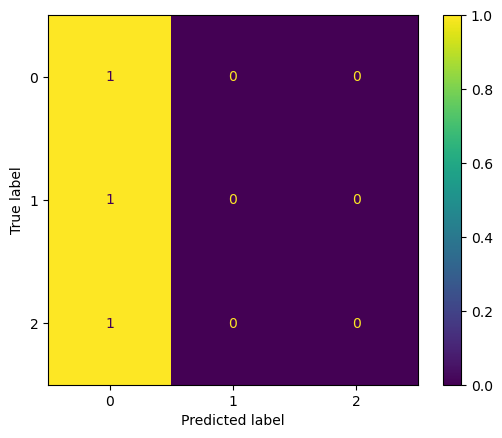

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.40437. Saving Model!
epoch 01, loss: 0.39204, acc: 0.89460, val_loss: 0.40437, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


epoch 02, loss: 0.39157, acc: 0.89462, val_loss: 0.40528, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 03, loss: 0.39114, acc: 0.89471, val_loss: 0.40664, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 04, loss: 0.39108, acc: 0.89471, val_loss: 0.40722, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 05, loss: 0.39078, acc: 0.89468, val_loss: 0.40786, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 06, loss: 0.39053, acc: 0.89468, val_loss: 0.40857, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 07, loss: 0.39022, acc: 0.89465, val_loss: 0.40926, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


epoch 08, loss: 0.39004, acc: 0.89468, val_loss: 0.40961, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 09, loss: 0.38985, acc: 0.89468, val_loss: 0.40971, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10it/s]


epoch 10, loss: 0.38960, acc: 0.89468, val_loss: 0.40989, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 11, loss: 0.38934, acc: 0.89465, val_loss: 0.41019, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 12, loss: 0.38911, acc: 0.89468, val_loss: 0.41048, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


epoch 13, loss: 0.38890, acc: 0.89468, val_loss: 0.41069, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 14, loss: 0.38866, acc: 0.89468, val_loss: 0.41092, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 15, loss: 0.38841, acc: 0.89468, val_loss: 0.41123, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 16, loss: 0.38817, acc: 0.89468, val_loss: 0.41157, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


epoch 17, loss: 0.38795, acc: 0.89468, val_loss: 0.41187, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 18, loss: 0.38772, acc: 0.89468, val_loss: 0.41215, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 19, loss: 0.38749, acc: 0.89468, val_loss: 0.41245, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]


epoch 20, loss: 0.38726, acc: 0.89471, val_loss: 0.41278, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 21, loss: 0.38703, acc: 0.89471, val_loss: 0.41312, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 22, loss: 0.38681, acc: 0.89474, val_loss: 0.41342, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 23, loss: 0.38658, acc: 0.89474, val_loss: 0.41373, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 24, loss: 0.38636, acc: 0.89474, val_loss: 0.41404, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 25, loss: 0.38613, acc: 0.89474, val_loss: 0.41440, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06it/s]


epoch 26, loss: 0.38590, acc: 0.89474, val_loss: 0.41475, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 27, loss: 0.38568, acc: 0.89474, val_loss: 0.41505, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 28, loss: 0.38546, acc: 0.89474, val_loss: 0.41539, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


epoch 29, loss: 0.38523, acc: 0.89474, val_loss: 0.41574, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 30, loss: 0.38502, acc: 0.89471, val_loss: 0.41612, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 31, loss: 0.38480, acc: 0.89471, val_loss: 0.41647, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 32, loss: 0.38458, acc: 0.89471, val_loss: 0.41680, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 33, loss: 0.38436, acc: 0.89471, val_loss: 0.41713, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 34, loss: 0.38413, acc: 0.89471, val_loss: 0.41743, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 35, loss: 0.38391, acc: 0.89471, val_loss: 0.41778, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 36, loss: 0.38369, acc: 0.89471, val_loss: 0.41816, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 37, loss: 0.38346, acc: 0.89471, val_loss: 0.41855, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24it/s]


epoch 38, loss: 0.38323, acc: 0.89471, val_loss: 0.41896, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 39, loss: 0.38300, acc: 0.89471, val_loss: 0.41933, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 40, loss: 0.38276, acc: 0.89471, val_loss: 0.41975, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


epoch 41, loss: 0.38252, acc: 0.89471, val_loss: 0.42012, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 42, loss: 0.38229, acc: 0.89471, val_loss: 0.42052, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 43, loss: 0.38206, acc: 0.89471, val_loss: 0.42097, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 44, loss: 0.38182, acc: 0.89474, val_loss: 0.42143, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


epoch 45, loss: 0.38157, acc: 0.89471, val_loss: 0.42188, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 46, loss: 0.38135, acc: 0.89471, val_loss: 0.42236, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 47, loss: 0.38111, acc: 0.89471, val_loss: 0.42276, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 48, loss: 0.38086, acc: 0.89471, val_loss: 0.42317, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 49, loss: 0.38060, acc: 0.89471, val_loss: 0.42366, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 50, loss: 0.38035, acc: 0.89471, val_loss: 0.42418, val_accuracy: 0.89175


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 51, loss: 0.38010, acc: 0.89471, val_loss: 0.42456, val_accuracy: 0.88702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 52, loss: 0.37985, acc: 0.89486, val_loss: 0.42510, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 53, loss: 0.37958, acc: 0.89486, val_loss: 0.42564, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 54, loss: 0.37929, acc: 0.89486, val_loss: 0.42619, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44it/s]


epoch 55, loss: 0.37903, acc: 0.89486, val_loss: 0.42654, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 56, loss: 0.37875, acc: 0.89486, val_loss: 0.42711, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 57, loss: 0.37848, acc: 0.89489, val_loss: 0.42791, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.23it/s]


epoch 58, loss: 0.37814, acc: 0.89489, val_loss: 0.42848, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 59, loss: 0.37788, acc: 0.89489, val_loss: 0.42882, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 60, loss: 0.37755, acc: 0.89489, val_loss: 0.42936, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 61, loss: 0.37722, acc: 0.89489, val_loss: 0.42983, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 62, loss: 0.37693, acc: 0.89489, val_loss: 0.43016, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 63, loss: 0.37659, acc: 0.89489, val_loss: 0.43105, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 64, loss: 0.37625, acc: 0.89489, val_loss: 0.43175, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 65, loss: 0.37596, acc: 0.89489, val_loss: 0.43207, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.48it/s]


epoch 66, loss: 0.37556, acc: 0.89489, val_loss: 0.43330, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 67, loss: 0.37521, acc: 0.89489, val_loss: 0.43465, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 68, loss: 0.37490, acc: 0.89489, val_loss: 0.43467, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 69, loss: 0.37453, acc: 0.89489, val_loss: 0.43501, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 70, loss: 0.37410, acc: 0.89489, val_loss: 0.43699, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 71, loss: 0.37378, acc: 0.89489, val_loss: 0.43715, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 72, loss: 0.37347, acc: 0.89489, val_loss: 0.43676, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10it/s]


epoch 73, loss: 0.37299, acc: 0.89489, val_loss: 0.43857, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 74, loss: 0.37255, acc: 0.89489, val_loss: 0.44106, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 75, loss: 0.37222, acc: 0.89489, val_loss: 0.44156, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01it/s]


epoch 76, loss: 0.37185, acc: 0.89489, val_loss: 0.44049, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 77, loss: 0.37146, acc: 0.89489, val_loss: 0.44087, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 78, loss: 0.37103, acc: 0.89486, val_loss: 0.44326, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 79, loss: 0.37063, acc: 0.89489, val_loss: 0.44494, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 80, loss: 0.37023, acc: 0.89492, val_loss: 0.44522, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 81, loss: 0.36976, acc: 0.89486, val_loss: 0.44631, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 82, loss: 0.36937, acc: 0.89489, val_loss: 0.44618, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27it/s]


epoch 83, loss: 0.36906, acc: 0.89492, val_loss: 0.44548, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 84, loss: 0.36857, acc: 0.89489, val_loss: 0.44757, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 85, loss: 0.36810, acc: 0.89492, val_loss: 0.44955, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.04it/s]


epoch 86, loss: 0.36766, acc: 0.89492, val_loss: 0.45009, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 87, loss: 0.36717, acc: 0.89495, val_loss: 0.45125, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 88, loss: 0.36671, acc: 0.89495, val_loss: 0.45185, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 89, loss: 0.36626, acc: 0.89495, val_loss: 0.45269, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 90, loss: 0.36582, acc: 0.89495, val_loss: 0.45464, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 91, loss: 0.36536, acc: 0.89495, val_loss: 0.45613, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 92, loss: 0.36496, acc: 0.89498, val_loss: 0.45700, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 93, loss: 0.36448, acc: 0.89498, val_loss: 0.45791, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


epoch 94, loss: 0.36402, acc: 0.89498, val_loss: 0.45944, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 95, loss: 0.36360, acc: 0.89495, val_loss: 0.46100, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 96, loss: 0.36311, acc: 0.89495, val_loss: 0.46264, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 97, loss: 0.36276, acc: 0.89498, val_loss: 0.46228, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 98, loss: 0.36238, acc: 0.89498, val_loss: 0.46221, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 99, loss: 0.36188, acc: 0.89509, val_loss: 0.46492, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 100, loss: 0.36144, acc: 0.89509, val_loss: 0.46771, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 101, loss: 0.36097, acc: 0.89518, val_loss: 0.47030, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 102, loss: 0.36053, acc: 0.89521, val_loss: 0.47159, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 103, loss: 0.36004, acc: 0.89518, val_loss: 0.47193, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 104, loss: 0.35956, acc: 0.89521, val_loss: 0.47399, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 105, loss: 0.35916, acc: 0.89524, val_loss: 0.47437, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 106, loss: 0.35874, acc: 0.89524, val_loss: 0.47513, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 107, loss: 0.35829, acc: 0.89521, val_loss: 0.47750, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 108, loss: 0.35783, acc: 0.89527, val_loss: 0.47888, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 109, loss: 0.35740, acc: 0.89530, val_loss: 0.47966, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 110, loss: 0.35689, acc: 0.89538, val_loss: 0.48184, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 111, loss: 0.35647, acc: 0.89538, val_loss: 0.48351, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 112, loss: 0.35604, acc: 0.89541, val_loss: 0.48496, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 113, loss: 0.35555, acc: 0.89541, val_loss: 0.48713, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.76it/s]


epoch 114, loss: 0.35512, acc: 0.89538, val_loss: 0.48872, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 115, loss: 0.35468, acc: 0.89541, val_loss: 0.49041, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 116, loss: 0.35422, acc: 0.89547, val_loss: 0.49241, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 117, loss: 0.35379, acc: 0.90058, val_loss: 0.49380, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 118, loss: 0.35334, acc: 0.90064, val_loss: 0.49517, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 119, loss: 0.35284, acc: 0.90073, val_loss: 0.49777, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 120, loss: 0.35246, acc: 0.90084, val_loss: 0.49953, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 121, loss: 0.35202, acc: 0.90084, val_loss: 0.50149, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 122, loss: 0.35153, acc: 0.90096, val_loss: 0.50271, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 123, loss: 0.35112, acc: 0.90099, val_loss: 0.50377, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


epoch 124, loss: 0.35068, acc: 0.90105, val_loss: 0.50465, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 125, loss: 0.35023, acc: 0.90108, val_loss: 0.50676, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 126, loss: 0.34979, acc: 0.90105, val_loss: 0.50813, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 127, loss: 0.34935, acc: 0.90108, val_loss: 0.50884, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 128, loss: 0.34888, acc: 0.90111, val_loss: 0.51044, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 129, loss: 0.34847, acc: 0.90116, val_loss: 0.51189, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 130, loss: 0.34800, acc: 0.90125, val_loss: 0.51287, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 131, loss: 0.34757, acc: 0.90114, val_loss: 0.51414, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 132, loss: 0.34713, acc: 0.90131, val_loss: 0.51589, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 133, loss: 0.34665, acc: 0.90131, val_loss: 0.51720, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 134, loss: 0.34621, acc: 0.90149, val_loss: 0.51784, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


epoch 135, loss: 0.34575, acc: 0.90146, val_loss: 0.51972, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 136, loss: 0.34536, acc: 0.90157, val_loss: 0.51973, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 137, loss: 0.34486, acc: 0.90154, val_loss: 0.52250, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 138, loss: 0.34443, acc: 0.90160, val_loss: 0.52268, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


epoch 139, loss: 0.34393, acc: 0.90163, val_loss: 0.52466, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 140, loss: 0.34346, acc: 0.90166, val_loss: 0.52467, val_accuracy: 0.88544


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 141, loss: 0.34299, acc: 0.90163, val_loss: 0.52694, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.80it/s]


epoch 142, loss: 0.34253, acc: 0.90157, val_loss: 0.52862, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 143, loss: 0.34212, acc: 0.90160, val_loss: 0.52857, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 144, loss: 0.34165, acc: 0.90163, val_loss: 0.53136, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 145, loss: 0.34122, acc: 0.90169, val_loss: 0.52986, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 146, loss: 0.34068, acc: 0.90172, val_loss: 0.53347, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 147, loss: 0.34029, acc: 0.90169, val_loss: 0.53370, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 148, loss: 0.33981, acc: 0.90175, val_loss: 0.53437, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 149, loss: 0.33936, acc: 0.90166, val_loss: 0.53711, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.58it/s]


epoch 150, loss: 0.33896, acc: 0.90181, val_loss: 0.53492, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 151, loss: 0.33850, acc: 0.90192, val_loss: 0.53989, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 152, loss: 0.33815, acc: 0.90184, val_loss: 0.53853, val_accuracy: 0.88282


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 153, loss: 0.33764, acc: 0.90207, val_loss: 0.54050, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 154, loss: 0.33729, acc: 0.90181, val_loss: 0.54320, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 155, loss: 0.33677, acc: 0.90207, val_loss: 0.53990, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 156, loss: 0.33638, acc: 0.90213, val_loss: 0.54432, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 157, loss: 0.33599, acc: 0.90204, val_loss: 0.54498, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 158, loss: 0.33542, acc: 0.90210, val_loss: 0.54459, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 159, loss: 0.33512, acc: 0.90213, val_loss: 0.54758, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.90it/s]


epoch 160, loss: 0.33455, acc: 0.90207, val_loss: 0.54786, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 161, loss: 0.33408, acc: 0.90222, val_loss: 0.54779, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 162, loss: 0.33387, acc: 0.90198, val_loss: 0.55227, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 163, loss: 0.33320, acc: 0.90216, val_loss: 0.55123, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 164, loss: 0.33284, acc: 0.90222, val_loss: 0.54893, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 165, loss: 0.33284, acc: 0.90201, val_loss: 0.55515, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 166, loss: 0.33201, acc: 0.90222, val_loss: 0.55261, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


epoch 167, loss: 0.33187, acc: 0.90242, val_loss: 0.55255, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 168, loss: 0.33178, acc: 0.90210, val_loss: 0.55933, val_accuracy: 0.87362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 169, loss: 0.33091, acc: 0.90225, val_loss: 0.55402, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14it/s]


epoch 170, loss: 0.33084, acc: 0.90265, val_loss: 0.55270, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 171, loss: 0.33109, acc: 0.90222, val_loss: 0.56067, val_accuracy: 0.87493


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 172, loss: 0.32990, acc: 0.90219, val_loss: 0.55574, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 173, loss: 0.33015, acc: 0.90254, val_loss: 0.55877, val_accuracy: 0.87625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 174, loss: 0.32985, acc: 0.90222, val_loss: 0.56033, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 175, loss: 0.32867, acc: 0.90265, val_loss: 0.55980, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 176, loss: 0.32879, acc: 0.90265, val_loss: 0.55773, val_accuracy: 0.87625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 177, loss: 0.32890, acc: 0.90230, val_loss: 0.56919, val_accuracy: 0.87257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.62it/s]


epoch 178, loss: 0.32812, acc: 0.90254, val_loss: 0.55910, val_accuracy: 0.87362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 179, loss: 0.32910, acc: 0.90268, val_loss: 0.56399, val_accuracy: 0.87310


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70it/s]


epoch 180, loss: 0.32829, acc: 0.90239, val_loss: 0.56730, val_accuracy: 0.87283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 181, loss: 0.32668, acc: 0.90286, val_loss: 0.56376, val_accuracy: 0.87651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 182, loss: 0.32743, acc: 0.90260, val_loss: 0.55999, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 183, loss: 0.32735, acc: 0.90274, val_loss: 0.57484, val_accuracy: 0.87467


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 184, loss: 0.32684, acc: 0.90274, val_loss: 0.57122, val_accuracy: 0.87257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94it/s]


epoch 185, loss: 0.32714, acc: 0.90295, val_loss: 0.57051, val_accuracy: 0.87336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 186, loss: 0.32685, acc: 0.90257, val_loss: 0.57279, val_accuracy: 0.87283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 187, loss: 0.32428, acc: 0.90318, val_loss: 0.57712, val_accuracy: 0.87283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.64it/s]


epoch 188, loss: 0.32425, acc: 0.90324, val_loss: 0.56392, val_accuracy: 0.87336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 189, loss: 0.32519, acc: 0.90292, val_loss: 0.57355, val_accuracy: 0.87257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 190, loss: 0.32429, acc: 0.90298, val_loss: 0.57648, val_accuracy: 0.87283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 191, loss: 0.32376, acc: 0.90324, val_loss: 0.56699, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 192, loss: 0.32411, acc: 0.90298, val_loss: 0.56640, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 193, loss: 0.32315, acc: 0.90312, val_loss: 0.58268, val_accuracy: 0.87204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 194, loss: 0.32223, acc: 0.90318, val_loss: 0.57311, val_accuracy: 0.87336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 195, loss: 0.32357, acc: 0.90318, val_loss: 0.56932, val_accuracy: 0.87310


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 196, loss: 0.32292, acc: 0.90300, val_loss: 0.57316, val_accuracy: 0.87283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 197, loss: 0.32130, acc: 0.90333, val_loss: 0.58479, val_accuracy: 0.87204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


epoch 198, loss: 0.32094, acc: 0.90338, val_loss: 0.57065, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 199, loss: 0.32269, acc: 0.90344, val_loss: 0.57179, val_accuracy: 0.87493


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


epoch 200, loss: 0.32176, acc: 0.90283, val_loss: 0.57712, val_accuracy: 0.87283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 201, loss: 0.32010, acc: 0.90356, val_loss: 0.58911, val_accuracy: 0.87204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 202, loss: 0.31966, acc: 0.90347, val_loss: 0.56947, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 203, loss: 0.32166, acc: 0.90350, val_loss: 0.57210, val_accuracy: 0.87493


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 204, loss: 0.32122, acc: 0.90292, val_loss: 0.57742, val_accuracy: 0.87467


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 205, loss: 0.31910, acc: 0.90350, val_loss: 0.58875, val_accuracy: 0.87204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s]


epoch 206, loss: 0.31814, acc: 0.90353, val_loss: 0.57421, val_accuracy: 0.87310


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 207, loss: 0.32017, acc: 0.90365, val_loss: 0.57461, val_accuracy: 0.87467


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 208, loss: 0.31982, acc: 0.90303, val_loss: 0.58397, val_accuracy: 0.87231


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 209, loss: 0.31736, acc: 0.90394, val_loss: 0.58714, val_accuracy: 0.87415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


epoch 210, loss: 0.31724, acc: 0.90420, val_loss: 0.57135, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 211, loss: 0.31980, acc: 0.90385, val_loss: 0.57780, val_accuracy: 0.87257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 212, loss: 0.31958, acc: 0.90327, val_loss: 0.59275, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 213, loss: 0.31719, acc: 0.90388, val_loss: 0.58475, val_accuracy: 0.87467


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 214, loss: 0.31818, acc: 0.90400, val_loss: 0.56981, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 215, loss: 0.32117, acc: 0.90353, val_loss: 0.58403, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 216, loss: 0.32165, acc: 0.90303, val_loss: 0.59365, val_accuracy: 0.86101


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 217, loss: 0.31845, acc: 0.90408, val_loss: 0.58931, val_accuracy: 0.87257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 218, loss: 0.31988, acc: 0.90333, val_loss: 0.57088, val_accuracy: 0.87257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 219, loss: 0.31862, acc: 0.90338, val_loss: 0.60702, val_accuracy: 0.85917


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 220, loss: 0.32011, acc: 0.90408, val_loss: 0.58936, val_accuracy: 0.85970


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 221, loss: 0.32153, acc: 0.90382, val_loss: 0.57299, val_accuracy: 0.88203


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 222, loss: 0.32296, acc: 0.90265, val_loss: 0.57516, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 223, loss: 0.31793, acc: 0.90327, val_loss: 0.60609, val_accuracy: 0.85733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 224, loss: 0.31664, acc: 0.90417, val_loss: 0.57894, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


epoch 225, loss: 0.32128, acc: 0.90353, val_loss: 0.56744, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92it/s]


epoch 226, loss: 0.32161, acc: 0.90338, val_loss: 0.61018, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39it/s]


epoch 227, loss: 0.31951, acc: 0.90423, val_loss: 0.58876, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 228, loss: 0.32220, acc: 0.90324, val_loss: 0.57431, val_accuracy: 0.88177


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 229, loss: 0.32065, acc: 0.90260, val_loss: 0.60945, val_accuracy: 0.85996


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 230, loss: 0.31543, acc: 0.90444, val_loss: 0.60219, val_accuracy: 0.85786


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 231, loss: 0.31733, acc: 0.90414, val_loss: 0.56820, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 232, loss: 0.31601, acc: 0.90312, val_loss: 0.57990, val_accuracy: 0.87126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 233, loss: 0.31391, acc: 0.90385, val_loss: 0.60100, val_accuracy: 0.86101


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 234, loss: 0.31312, acc: 0.90429, val_loss: 0.57812, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 235, loss: 0.31406, acc: 0.90420, val_loss: 0.57917, val_accuracy: 0.87257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 236, loss: 0.31314, acc: 0.90350, val_loss: 0.60588, val_accuracy: 0.85891


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 237, loss: 0.31117, acc: 0.90435, val_loss: 0.58404, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 238, loss: 0.31382, acc: 0.90417, val_loss: 0.57374, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 239, loss: 0.31199, acc: 0.90359, val_loss: 0.59514, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 240, loss: 0.30921, acc: 0.90467, val_loss: 0.59034, val_accuracy: 0.86311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 241, loss: 0.30971, acc: 0.90461, val_loss: 0.57983, val_accuracy: 0.87546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 242, loss: 0.31002, acc: 0.90406, val_loss: 0.59151, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 243, loss: 0.30876, acc: 0.90446, val_loss: 0.59977, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 244, loss: 0.30810, acc: 0.90420, val_loss: 0.58260, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 245, loss: 0.31182, acc: 0.90400, val_loss: 0.57981, val_accuracy: 0.87441


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 246, loss: 0.31047, acc: 0.90382, val_loss: 0.60977, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 247, loss: 0.30717, acc: 0.90502, val_loss: 0.59423, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 248, loss: 0.30918, acc: 0.90429, val_loss: 0.57702, val_accuracy: 0.88177


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 249, loss: 0.31042, acc: 0.90432, val_loss: 0.59668, val_accuracy: 0.86337


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 250, loss: 0.30791, acc: 0.90464, val_loss: 0.61269, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 251, loss: 0.30668, acc: 0.90470, val_loss: 0.58695, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 252, loss: 0.31033, acc: 0.90394, val_loss: 0.57887, val_accuracy: 0.88124


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 253, loss: 0.30974, acc: 0.90385, val_loss: 0.62341, val_accuracy: 0.85917


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 254, loss: 0.30858, acc: 0.90540, val_loss: 0.60085, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47it/s]


epoch 255, loss: 0.31152, acc: 0.90435, val_loss: 0.58191, val_accuracy: 0.88177


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 256, loss: 0.31373, acc: 0.90353, val_loss: 0.59135, val_accuracy: 0.86337


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


epoch 257, loss: 0.31050, acc: 0.90394, val_loss: 0.63984, val_accuracy: 0.85523


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 258, loss: 0.31001, acc: 0.90511, val_loss: 0.59103, val_accuracy: 0.87520


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 259, loss: 0.31640, acc: 0.90204, val_loss: 0.57474, val_accuracy: 0.88177


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 260, loss: 0.31391, acc: 0.90365, val_loss: 0.62833, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 261, loss: 0.31038, acc: 0.90543, val_loss: 0.60555, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 262, loss: 0.31198, acc: 0.90458, val_loss: 0.58376, val_accuracy: 0.87888


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 263, loss: 0.31285, acc: 0.90335, val_loss: 0.61369, val_accuracy: 0.86048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 264, loss: 0.30807, acc: 0.90476, val_loss: 0.61570, val_accuracy: 0.85917


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 265, loss: 0.30905, acc: 0.90438, val_loss: 0.58361, val_accuracy: 0.88150


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 266, loss: 0.31151, acc: 0.90391, val_loss: 0.58827, val_accuracy: 0.86311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 267, loss: 0.31095, acc: 0.90379, val_loss: 0.63434, val_accuracy: 0.85681


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 268, loss: 0.30920, acc: 0.90458, val_loss: 0.59789, val_accuracy: 0.88150


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 269, loss: 0.31497, acc: 0.90338, val_loss: 0.58651, val_accuracy: 0.86337


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 270, loss: 0.30951, acc: 0.90368, val_loss: 0.61457, val_accuracy: 0.85864


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 271, loss: 0.30637, acc: 0.90467, val_loss: 0.59653, val_accuracy: 0.88150


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.55it/s]


epoch 272, loss: 0.31095, acc: 0.90464, val_loss: 0.61283, val_accuracy: 0.86180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 273, loss: 0.30902, acc: 0.90458, val_loss: 0.60510, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 274, loss: 0.31198, acc: 0.90376, val_loss: 0.58601, val_accuracy: 0.88150


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 275, loss: 0.31363, acc: 0.90356, val_loss: 0.61508, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 276, loss: 0.31198, acc: 0.90458, val_loss: 0.61052, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 277, loss: 0.31339, acc: 0.90379, val_loss: 0.58986, val_accuracy: 0.87861


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 278, loss: 0.31167, acc: 0.90446, val_loss: 0.61694, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 279, loss: 0.30685, acc: 0.90484, val_loss: 0.60198, val_accuracy: 0.86337


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 280, loss: 0.31290, acc: 0.90382, val_loss: 0.58542, val_accuracy: 0.86442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 281, loss: 0.30673, acc: 0.90449, val_loss: 0.60229, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 282, loss: 0.30341, acc: 0.90487, val_loss: 0.60375, val_accuracy: 0.87178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 283, loss: 0.31126, acc: 0.90394, val_loss: 0.60169, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 284, loss: 0.30611, acc: 0.90446, val_loss: 0.58615, val_accuracy: 0.86889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 285, loss: 0.30506, acc: 0.90446, val_loss: 0.60133, val_accuracy: 0.88150


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 286, loss: 0.31282, acc: 0.90458, val_loss: 0.65131, val_accuracy: 0.83526


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 287, loss: 0.31238, acc: 0.90420, val_loss: 0.59354, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 288, loss: 0.31723, acc: 0.90382, val_loss: 0.58453, val_accuracy: 0.87888


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 289, loss: 0.31588, acc: 0.90385, val_loss: 0.62154, val_accuracy: 0.83841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68it/s]


epoch 290, loss: 0.31127, acc: 0.90534, val_loss: 0.61099, val_accuracy: 0.87835


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 291, loss: 0.32310, acc: 0.90347, val_loss: 0.59473, val_accuracy: 0.86364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 292, loss: 0.31055, acc: 0.90397, val_loss: 0.55613, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 293, loss: 0.30431, acc: 0.90400, val_loss: 0.60602, val_accuracy: 0.86259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 294, loss: 0.31181, acc: 0.90467, val_loss: 0.59937, val_accuracy: 0.86285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 295, loss: 0.30135, acc: 0.90546, val_loss: 0.56233, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


epoch 296, loss: 0.29935, acc: 0.90473, val_loss: 0.60016, val_accuracy: 0.86101


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 297, loss: 0.29895, acc: 0.90517, val_loss: 0.58201, val_accuracy: 0.86442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 298, loss: 0.29744, acc: 0.90511, val_loss: 0.58668, val_accuracy: 0.86416


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 299, loss: 0.29645, acc: 0.90531, val_loss: 0.59068, val_accuracy: 0.86153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 300, loss: 0.29576, acc: 0.90595, val_loss: 0.58978, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 301, loss: 0.29592, acc: 0.90572, val_loss: 0.60137, val_accuracy: 0.86180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 302, loss: 0.29466, acc: 0.90592, val_loss: 0.59215, val_accuracy: 0.86364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 303, loss: 0.29554, acc: 0.90563, val_loss: 0.59248, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


epoch 304, loss: 0.29510, acc: 0.90563, val_loss: 0.60676, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 305, loss: 0.29356, acc: 0.90607, val_loss: 0.59668, val_accuracy: 0.86364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 306, loss: 0.29518, acc: 0.90560, val_loss: 0.59187, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 307, loss: 0.29426, acc: 0.90563, val_loss: 0.61501, val_accuracy: 0.86180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 308, loss: 0.29295, acc: 0.90607, val_loss: 0.59913, val_accuracy: 0.86390


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 309, loss: 0.29474, acc: 0.90610, val_loss: 0.59587, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]


epoch 310, loss: 0.29389, acc: 0.90572, val_loss: 0.62201, val_accuracy: 0.86075


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


epoch 311, loss: 0.29238, acc: 0.90607, val_loss: 0.59932, val_accuracy: 0.86416


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 312, loss: 0.29487, acc: 0.90639, val_loss: 0.59679, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 313, loss: 0.29386, acc: 0.90557, val_loss: 0.62869, val_accuracy: 0.86022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 314, loss: 0.29178, acc: 0.90639, val_loss: 0.60474, val_accuracy: 0.86390


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 315, loss: 0.29386, acc: 0.90630, val_loss: 0.59685, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 316, loss: 0.29311, acc: 0.90607, val_loss: 0.62914, val_accuracy: 0.86048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 317, loss: 0.29086, acc: 0.90636, val_loss: 0.61060, val_accuracy: 0.86364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 318, loss: 0.29227, acc: 0.90633, val_loss: 0.59904, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 319, loss: 0.29304, acc: 0.90610, val_loss: 0.62578, val_accuracy: 0.86075


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 320, loss: 0.29068, acc: 0.90712, val_loss: 0.62765, val_accuracy: 0.86048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 321, loss: 0.29096, acc: 0.90660, val_loss: 0.59920, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 322, loss: 0.29449, acc: 0.90587, val_loss: 0.60950, val_accuracy: 0.86994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 323, loss: 0.29299, acc: 0.90636, val_loss: 0.65632, val_accuracy: 0.84524


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 324, loss: 0.29137, acc: 0.90730, val_loss: 0.62125, val_accuracy: 0.86994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 325, loss: 0.29362, acc: 0.90657, val_loss: 0.60054, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 326, loss: 0.29452, acc: 0.90610, val_loss: 0.64174, val_accuracy: 0.84708


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 327, loss: 0.29254, acc: 0.90677, val_loss: 0.63878, val_accuracy: 0.86022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 328, loss: 0.29255, acc: 0.90665, val_loss: 0.60687, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 329, loss: 0.29791, acc: 0.90546, val_loss: 0.61862, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 330, loss: 0.29450, acc: 0.90674, val_loss: 0.67271, val_accuracy: 0.83342


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 331, loss: 0.29273, acc: 0.90852, val_loss: 0.61095, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 332, loss: 0.29710, acc: 0.90560, val_loss: 0.59544, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 333, loss: 0.29367, acc: 0.90616, val_loss: 0.66487, val_accuracy: 0.83395


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 334, loss: 0.29140, acc: 0.90800, val_loss: 0.62870, val_accuracy: 0.85996


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 335, loss: 0.29290, acc: 0.90727, val_loss: 0.60372, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 336, loss: 0.29485, acc: 0.90674, val_loss: 0.63449, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 337, loss: 0.29101, acc: 0.90671, val_loss: 0.66017, val_accuracy: 0.83027


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 338, loss: 0.29031, acc: 0.90785, val_loss: 0.61237, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 339, loss: 0.29491, acc: 0.90607, val_loss: 0.61122, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 340, loss: 0.29087, acc: 0.90689, val_loss: 0.67667, val_accuracy: 0.82160


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 341, loss: 0.29008, acc: 0.90844, val_loss: 0.62011, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 342, loss: 0.29350, acc: 0.90800, val_loss: 0.60302, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 343, loss: 0.29351, acc: 0.90627, val_loss: 0.65854, val_accuracy: 0.83868


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 344, loss: 0.29047, acc: 0.90806, val_loss: 0.64899, val_accuracy: 0.85733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 345, loss: 0.29115, acc: 0.90750, val_loss: 0.60854, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 346, loss: 0.29513, acc: 0.90698, val_loss: 0.62831, val_accuracy: 0.86837


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 347, loss: 0.29037, acc: 0.90683, val_loss: 0.67987, val_accuracy: 0.82160


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 348, loss: 0.29001, acc: 0.90794, val_loss: 0.61593, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 349, loss: 0.29486, acc: 0.90642, val_loss: 0.61179, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 350, loss: 0.29077, acc: 0.90689, val_loss: 0.68570, val_accuracy: 0.82002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 351, loss: 0.28897, acc: 0.90879, val_loss: 0.63368, val_accuracy: 0.86863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 352, loss: 0.29123, acc: 0.90747, val_loss: 0.61124, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 353, loss: 0.29098, acc: 0.90698, val_loss: 0.65625, val_accuracy: 0.84892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 354, loss: 0.28710, acc: 0.90855, val_loss: 0.66105, val_accuracy: 0.84393


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 355, loss: 0.28717, acc: 0.90838, val_loss: 0.61679, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 356, loss: 0.29112, acc: 0.90715, val_loss: 0.62859, val_accuracy: 0.86889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 357, loss: 0.28710, acc: 0.90712, val_loss: 0.68489, val_accuracy: 0.79874


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 358, loss: 0.28564, acc: 0.90902, val_loss: 0.62727, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 359, loss: 0.28964, acc: 0.90794, val_loss: 0.61684, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 360, loss: 0.28706, acc: 0.90741, val_loss: 0.67355, val_accuracy: 0.82659


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 361, loss: 0.28458, acc: 0.90914, val_loss: 0.65316, val_accuracy: 0.85996


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 362, loss: 0.28504, acc: 0.90884, val_loss: 0.62011, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 363, loss: 0.28826, acc: 0.90721, val_loss: 0.63790, val_accuracy: 0.86810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 364, loss: 0.28528, acc: 0.90794, val_loss: 0.69459, val_accuracy: 0.80373


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 365, loss: 0.28470, acc: 0.91010, val_loss: 0.63528, val_accuracy: 0.86915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 366, loss: 0.28990, acc: 0.90808, val_loss: 0.61609, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 367, loss: 0.28897, acc: 0.90674, val_loss: 0.68208, val_accuracy: 0.82948


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 368, loss: 0.28801, acc: 0.90879, val_loss: 0.68120, val_accuracy: 0.83762


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 369, loss: 0.28798, acc: 0.90814, val_loss: 0.62592, val_accuracy: 0.87099


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 370, loss: 0.29328, acc: 0.90712, val_loss: 0.63520, val_accuracy: 0.86784


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 371, loss: 0.28684, acc: 0.90776, val_loss: 0.70492, val_accuracy: 0.80084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 372, loss: 0.28535, acc: 0.90943, val_loss: 0.63167, val_accuracy: 0.86942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 373, loss: 0.28963, acc: 0.90806, val_loss: 0.62624, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 374, loss: 0.28443, acc: 0.90791, val_loss: 0.68702, val_accuracy: 0.82370


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 375, loss: 0.28204, acc: 0.91042, val_loss: 0.65590, val_accuracy: 0.85996


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 376, loss: 0.28308, acc: 0.90940, val_loss: 0.62687, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 377, loss: 0.28576, acc: 0.90765, val_loss: 0.65321, val_accuracy: 0.86679


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 378, loss: 0.28292, acc: 0.90829, val_loss: 0.70371, val_accuracy: 0.80189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18it/s]


epoch 379, loss: 0.28189, acc: 0.91080, val_loss: 0.63985, val_accuracy: 0.86915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 380, loss: 0.28648, acc: 0.90817, val_loss: 0.62641, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 381, loss: 0.28324, acc: 0.90791, val_loss: 0.69020, val_accuracy: 0.82633


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 382, loss: 0.28155, acc: 0.91074, val_loss: 0.67639, val_accuracy: 0.84472


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 383, loss: 0.28207, acc: 0.90937, val_loss: 0.63488, val_accuracy: 0.87047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 384, loss: 0.28604, acc: 0.90762, val_loss: 0.64322, val_accuracy: 0.86784


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 385, loss: 0.28326, acc: 0.90814, val_loss: 0.72193, val_accuracy: 0.80084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 386, loss: 0.28279, acc: 0.91027, val_loss: 0.65489, val_accuracy: 0.86232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 387, loss: 0.28719, acc: 0.90896, val_loss: 0.62650, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 388, loss: 0.28700, acc: 0.90730, val_loss: 0.68530, val_accuracy: 0.83053


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 389, loss: 0.28544, acc: 0.90873, val_loss: 0.71412, val_accuracy: 0.80032


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 390, loss: 0.28587, acc: 0.90919, val_loss: 0.63083, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.80it/s]


epoch 391, loss: 0.29336, acc: 0.90797, val_loss: 0.62864, val_accuracy: 0.86942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


epoch 392, loss: 0.28650, acc: 0.90771, val_loss: 0.73709, val_accuracy: 0.79848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 393, loss: 0.28577, acc: 0.90922, val_loss: 0.65902, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06it/s]


epoch 394, loss: 0.28703, acc: 0.90896, val_loss: 0.63290, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


epoch 395, loss: 0.28434, acc: 0.90768, val_loss: 0.68718, val_accuracy: 0.83001


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 396, loss: 0.28152, acc: 0.91030, val_loss: 0.69071, val_accuracy: 0.83316


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 397, loss: 0.28210, acc: 0.91016, val_loss: 0.64202, val_accuracy: 0.86994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 398, loss: 0.28767, acc: 0.90738, val_loss: 0.67291, val_accuracy: 0.85575


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 399, loss: 0.28391, acc: 0.90905, val_loss: 0.73573, val_accuracy: 0.79743


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 400, loss: 0.28282, acc: 0.90984, val_loss: 0.65365, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 401, loss: 0.28823, acc: 0.90800, val_loss: 0.65691, val_accuracy: 0.86679


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 402, loss: 0.28103, acc: 0.90922, val_loss: 0.72370, val_accuracy: 0.80058


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 403, loss: 0.27837, acc: 0.91060, val_loss: 0.65733, val_accuracy: 0.86837


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 404, loss: 0.28080, acc: 0.90981, val_loss: 0.65089, val_accuracy: 0.86810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 405, loss: 0.27799, acc: 0.90960, val_loss: 0.69598, val_accuracy: 0.82843


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 406, loss: 0.27610, acc: 0.91118, val_loss: 0.68765, val_accuracy: 0.83762


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 407, loss: 0.27657, acc: 0.91060, val_loss: 0.65362, val_accuracy: 0.86863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 408, loss: 0.27864, acc: 0.90957, val_loss: 0.67008, val_accuracy: 0.86600


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 409, loss: 0.27637, acc: 0.91001, val_loss: 0.72889, val_accuracy: 0.81897


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 410, loss: 0.27589, acc: 0.91168, val_loss: 0.67520, val_accuracy: 0.86127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 411, loss: 0.27887, acc: 0.90998, val_loss: 0.64795, val_accuracy: 0.86942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


epoch 412, loss: 0.27953, acc: 0.90917, val_loss: 0.69619, val_accuracy: 0.83158


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 413, loss: 0.27939, acc: 0.91039, val_loss: 0.74087, val_accuracy: 0.78954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


epoch 414, loss: 0.27951, acc: 0.91095, val_loss: 0.65711, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 415, loss: 0.28659, acc: 0.90861, val_loss: 0.64282, val_accuracy: 0.86889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 416, loss: 0.28221, acc: 0.90829, val_loss: 0.76028, val_accuracy: 0.78849


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 417, loss: 0.28460, acc: 0.90940, val_loss: 0.69372, val_accuracy: 0.84157


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


epoch 418, loss: 0.28689, acc: 0.90855, val_loss: 0.64610, val_accuracy: 0.87020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 419, loss: 0.29008, acc: 0.90782, val_loss: 0.69316, val_accuracy: 0.83500


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 420, loss: 0.28145, acc: 0.90952, val_loss: 0.74604, val_accuracy: 0.78744


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 421, loss: 0.28033, acc: 0.91130, val_loss: 0.65304, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 422, loss: 0.28432, acc: 0.90902, val_loss: 0.66865, val_accuracy: 0.84104


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 423, loss: 0.27636, acc: 0.90984, val_loss: 0.73268, val_accuracy: 0.82475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 424, loss: 0.27488, acc: 0.91095, val_loss: 0.66934, val_accuracy: 0.86837


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 425, loss: 0.27764, acc: 0.91025, val_loss: 0.68311, val_accuracy: 0.84104


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 426, loss: 0.27333, acc: 0.91027, val_loss: 0.71394, val_accuracy: 0.82817


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 427, loss: 0.27151, acc: 0.91156, val_loss: 0.68602, val_accuracy: 0.84130


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.39it/s]


epoch 428, loss: 0.27308, acc: 0.91112, val_loss: 0.67929, val_accuracy: 0.86048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 429, loss: 0.27205, acc: 0.91065, val_loss: 0.70327, val_accuracy: 0.83342


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.46it/s]


epoch 430, loss: 0.27099, acc: 0.91121, val_loss: 0.71898, val_accuracy: 0.78744


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 431, loss: 0.27080, acc: 0.91200, val_loss: 0.68360, val_accuracy: 0.86048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 432, loss: 0.27249, acc: 0.91071, val_loss: 0.67617, val_accuracy: 0.86679


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 433, loss: 0.27256, acc: 0.91080, val_loss: 0.72640, val_accuracy: 0.82606


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80it/s]


epoch 434, loss: 0.27189, acc: 0.91165, val_loss: 0.73511, val_accuracy: 0.79900


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


epoch 435, loss: 0.27262, acc: 0.91159, val_loss: 0.67425, val_accuracy: 0.86915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.67it/s]


epoch 436, loss: 0.27753, acc: 0.91027, val_loss: 0.67328, val_accuracy: 0.85707


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 437, loss: 0.27773, acc: 0.91025, val_loss: 0.78405, val_accuracy: 0.77798


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 438, loss: 0.27974, acc: 0.91127, val_loss: 0.72360, val_accuracy: 0.82869


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 439, loss: 0.28379, acc: 0.90779, val_loss: 0.65061, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 440, loss: 0.28953, acc: 0.90806, val_loss: 0.68952, val_accuracy: 0.83263


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 441, loss: 0.28368, acc: 0.90981, val_loss: 0.82266, val_accuracy: 0.75696


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47it/s]


epoch 442, loss: 0.28362, acc: 0.90849, val_loss: 0.67477, val_accuracy: 0.85470


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 443, loss: 0.28908, acc: 0.90908, val_loss: 0.64720, val_accuracy: 0.86863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


epoch 444, loss: 0.28154, acc: 0.90879, val_loss: 0.77303, val_accuracy: 0.77352


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 445, loss: 0.27920, acc: 0.91030, val_loss: 0.70831, val_accuracy: 0.82738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 446, loss: 0.27993, acc: 0.91039, val_loss: 0.66275, val_accuracy: 0.86942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 447, loss: 0.28097, acc: 0.90841, val_loss: 0.72192, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 448, loss: 0.27537, acc: 0.91118, val_loss: 0.76552, val_accuracy: 0.78902


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 449, loss: 0.27448, acc: 0.91238, val_loss: 0.68037, val_accuracy: 0.86968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 450, loss: 0.27902, acc: 0.90995, val_loss: 0.71278, val_accuracy: 0.77982


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 451, loss: 0.27187, acc: 0.91095, val_loss: 0.75281, val_accuracy: 0.81582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 452, loss: 0.27089, acc: 0.91244, val_loss: 0.68464, val_accuracy: 0.84919


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 453, loss: 0.27382, acc: 0.91098, val_loss: 0.71140, val_accuracy: 0.78586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


epoch 454, loss: 0.26962, acc: 0.91103, val_loss: 0.74645, val_accuracy: 0.77378


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 455, loss: 0.26772, acc: 0.91308, val_loss: 0.71594, val_accuracy: 0.78665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 456, loss: 0.26899, acc: 0.91176, val_loss: 0.70271, val_accuracy: 0.84288


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 457, loss: 0.26809, acc: 0.91147, val_loss: 0.72627, val_accuracy: 0.77614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 458, loss: 0.26723, acc: 0.91194, val_loss: 0.74774, val_accuracy: 0.77772


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 459, loss: 0.26680, acc: 0.91264, val_loss: 0.71165, val_accuracy: 0.83368


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 460, loss: 0.26824, acc: 0.91188, val_loss: 0.70504, val_accuracy: 0.78902


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 461, loss: 0.26844, acc: 0.91133, val_loss: 0.75486, val_accuracy: 0.77693


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


epoch 462, loss: 0.26784, acc: 0.91238, val_loss: 0.76674, val_accuracy: 0.74908


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 463, loss: 0.26848, acc: 0.91258, val_loss: 0.69933, val_accuracy: 0.79769


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 464, loss: 0.27332, acc: 0.91106, val_loss: 0.69683, val_accuracy: 0.84892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 465, loss: 0.27364, acc: 0.91057, val_loss: 0.81190, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 466, loss: 0.27611, acc: 0.91141, val_loss: 0.75504, val_accuracy: 0.77141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 467, loss: 0.28024, acc: 0.90844, val_loss: 0.66818, val_accuracy: 0.87073


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 468, loss: 0.28694, acc: 0.90808, val_loss: 0.71004, val_accuracy: 0.78297


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 469, loss: 0.28192, acc: 0.91001, val_loss: 0.87168, val_accuracy: 0.70047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 470, loss: 0.28352, acc: 0.90917, val_loss: 0.69095, val_accuracy: 0.85418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 471, loss: 0.29011, acc: 0.90876, val_loss: 0.66731, val_accuracy: 0.82081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 472, loss: 0.27890, acc: 0.90954, val_loss: 0.81013, val_accuracy: 0.73778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 473, loss: 0.27526, acc: 0.91127, val_loss: 0.72326, val_accuracy: 0.82764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 474, loss: 0.27595, acc: 0.91133, val_loss: 0.68776, val_accuracy: 0.86048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


epoch 475, loss: 0.27462, acc: 0.90984, val_loss: 0.76275, val_accuracy: 0.77010


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 476, loss: 0.27060, acc: 0.91252, val_loss: 0.78746, val_accuracy: 0.73962


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 477, loss: 0.27052, acc: 0.91252, val_loss: 0.70316, val_accuracy: 0.85444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 478, loss: 0.27403, acc: 0.91089, val_loss: 0.74624, val_accuracy: 0.77798


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 479, loss: 0.26905, acc: 0.91144, val_loss: 0.79433, val_accuracy: 0.74172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 480, loss: 0.26851, acc: 0.91308, val_loss: 0.70483, val_accuracy: 0.79637


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 481, loss: 0.27218, acc: 0.91188, val_loss: 0.72757, val_accuracy: 0.78219


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 482, loss: 0.26737, acc: 0.91121, val_loss: 0.78607, val_accuracy: 0.77010


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 483, loss: 0.26584, acc: 0.91317, val_loss: 0.74728, val_accuracy: 0.78219


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 484, loss: 0.26657, acc: 0.91249, val_loss: 0.72019, val_accuracy: 0.78797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


epoch 485, loss: 0.26670, acc: 0.91206, val_loss: 0.75132, val_accuracy: 0.77378


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 486, loss: 0.26550, acc: 0.91138, val_loss: 0.80566, val_accuracy: 0.73962


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 487, loss: 0.26548, acc: 0.91398, val_loss: 0.73091, val_accuracy: 0.78665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 488, loss: 0.26892, acc: 0.91232, val_loss: 0.70869, val_accuracy: 0.79664


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 489, loss: 0.26933, acc: 0.91095, val_loss: 0.79972, val_accuracy: 0.76406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 490, loss: 0.26980, acc: 0.91220, val_loss: 0.80594, val_accuracy: 0.73962


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 491, loss: 0.27030, acc: 0.91270, val_loss: 0.71163, val_accuracy: 0.81529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 492, loss: 0.27742, acc: 0.91127, val_loss: 0.72914, val_accuracy: 0.77641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 493, loss: 0.27239, acc: 0.91074, val_loss: 0.86782, val_accuracy: 0.70757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 494, loss: 0.27433, acc: 0.91083, val_loss: 0.71730, val_accuracy: 0.78639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 495, loss: 0.27971, acc: 0.91100, val_loss: 0.69635, val_accuracy: 0.80951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87it/s]


epoch 496, loss: 0.27464, acc: 0.91030, val_loss: 0.81821, val_accuracy: 0.75460


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 497, loss: 0.26985, acc: 0.91182, val_loss: 0.79257, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80it/s]


epoch 498, loss: 0.26979, acc: 0.91258, val_loss: 0.71078, val_accuracy: 0.80820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 499, loss: 0.27341, acc: 0.91203, val_loss: 0.76455, val_accuracy: 0.77115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 500, loss: 0.26745, acc: 0.91156, val_loss: 0.83156, val_accuracy: 0.72438
2번째 교차검증
evaluation loss: 0.40437, evaluation accuracy: 0.89411
(5, 3806)
(3806, 5)
Learning rate set to 0.085251
0:	learn: 0.9834916	total: 11.4ms	remaining: 11.4s
1:	learn: 0.8932585	total: 23.9ms	remaining: 11.9s
2:	learn: 0.8205021	total: 35.9ms	remaining: 11.9s
3:	learn: 0.7606803	total: 59.8ms	remaining: 14.9s
4:	learn: 0.7107929	total: 73.5ms	remaining: 14.6s
5:	learn: 0.6687479	total: 86.9ms	remaining: 14.4s
6:	learn: 0.6330256	total: 100ms	remaining: 14.2s
7:	learn: 0.6024856	total: 122ms	remaining: 15.2s
8:	learn: 0.5762490	total: 136ms	remaining: 15s
9:	learn: 0.5536246	total: 153ms	remaining: 15.1s
10:	learn: 0.5340581	total: 166ms	remaining: 14.9s
11:	learn: 0.5170987	total: 177ms	remaining: 14.5s
12:	learn: 0.5023747	total: 190ms	remaining: 14.4s
13:	learn: 0.4895766	total: 203ms	remaining: 14.3s
14:	learn: 0.4784434	total: 216ms	remaining: 14.2s
15:	learn: 0.4687544	total: 226ms	remaining: 1

162:	learn: 0.4050991	total: 1.47s	remaining: 7.54s
163:	learn: 0.4050978	total: 1.48s	remaining: 7.53s
164:	learn: 0.4050966	total: 1.48s	remaining: 7.51s
165:	learn: 0.4050954	total: 1.5s	remaining: 7.55s
166:	learn: 0.4050942	total: 1.51s	remaining: 7.53s
167:	learn: 0.4050930	total: 1.52s	remaining: 7.52s
168:	learn: 0.4050919	total: 1.52s	remaining: 7.5s
169:	learn: 0.4050907	total: 1.53s	remaining: 7.48s
170:	learn: 0.4050897	total: 1.54s	remaining: 7.47s
171:	learn: 0.4050886	total: 1.55s	remaining: 7.46s
172:	learn: 0.4050875	total: 1.56s	remaining: 7.48s
173:	learn: 0.4050864	total: 1.57s	remaining: 7.47s
174:	learn: 0.4050853	total: 1.58s	remaining: 7.46s
175:	learn: 0.4050843	total: 1.59s	remaining: 7.45s
176:	learn: 0.4050833	total: 1.6s	remaining: 7.44s
177:	learn: 0.4050823	total: 1.61s	remaining: 7.43s
178:	learn: 0.4050814	total: 1.62s	remaining: 7.42s
179:	learn: 0.4050804	total: 1.63s	remaining: 7.41s
180:	learn: 0.4050795	total: 1.63s	remaining: 7.39s
181:	learn: 0.4

339:	learn: 0.4050144	total: 3.1s	remaining: 6.03s
340:	learn: 0.4050142	total: 3.11s	remaining: 6.02s
341:	learn: 0.4050141	total: 3.12s	remaining: 6.01s
342:	learn: 0.4050139	total: 3.13s	remaining: 6s
343:	learn: 0.4050137	total: 3.14s	remaining: 5.98s
344:	learn: 0.4050135	total: 3.15s	remaining: 5.98s
345:	learn: 0.4050134	total: 3.15s	remaining: 5.96s
346:	learn: 0.4050132	total: 3.16s	remaining: 5.96s
347:	learn: 0.4050130	total: 3.17s	remaining: 5.94s
348:	learn: 0.4050128	total: 3.18s	remaining: 5.93s
349:	learn: 0.4050127	total: 3.19s	remaining: 5.92s
350:	learn: 0.4050125	total: 3.21s	remaining: 5.93s
351:	learn: 0.4050124	total: 3.21s	remaining: 5.92s
352:	learn: 0.4050122	total: 3.22s	remaining: 5.9s
353:	learn: 0.4050120	total: 3.23s	remaining: 5.89s
354:	learn: 0.4050118	total: 3.23s	remaining: 5.88s
355:	learn: 0.4050117	total: 3.24s	remaining: 5.87s
356:	learn: 0.4050116	total: 3.25s	remaining: 5.86s
357:	learn: 0.4050114	total: 3.27s	remaining: 5.86s
358:	learn: 0.405

499:	learn: 0.4049965	total: 4.54s	remaining: 4.54s
500:	learn: 0.4049964	total: 4.55s	remaining: 4.53s
501:	learn: 0.4049963	total: 4.56s	remaining: 4.52s
502:	learn: 0.4049963	total: 4.56s	remaining: 4.51s
503:	learn: 0.4049962	total: 4.57s	remaining: 4.5s
504:	learn: 0.4049961	total: 4.58s	remaining: 4.49s
505:	learn: 0.4049960	total: 4.59s	remaining: 4.48s
506:	learn: 0.4049960	total: 4.6s	remaining: 4.47s
507:	learn: 0.4049959	total: 4.61s	remaining: 4.46s
508:	learn: 0.4049958	total: 4.62s	remaining: 4.45s
509:	learn: 0.4049957	total: 4.62s	remaining: 4.44s
510:	learn: 0.4049957	total: 4.63s	remaining: 4.43s
511:	learn: 0.4049956	total: 4.64s	remaining: 4.42s
512:	learn: 0.4049956	total: 4.65s	remaining: 4.41s
513:	learn: 0.4049955	total: 4.66s	remaining: 4.4s
514:	learn: 0.4049954	total: 4.66s	remaining: 4.39s
515:	learn: 0.4049954	total: 4.67s	remaining: 4.38s
516:	learn: 0.4049953	total: 4.68s	remaining: 4.37s
517:	learn: 0.4049952	total: 4.69s	remaining: 4.36s
518:	learn: 0.4

662:	learn: 0.4049881	total: 5.99s	remaining: 3.04s
663:	learn: 0.4049881	total: 5.99s	remaining: 3.03s
664:	learn: 0.4049881	total: 6s	remaining: 3.02s
665:	learn: 0.4049880	total: 6.01s	remaining: 3.01s
666:	learn: 0.4049880	total: 6.02s	remaining: 3s
667:	learn: 0.4049879	total: 6.03s	remaining: 3s
668:	learn: 0.4049879	total: 6.04s	remaining: 2.99s
669:	learn: 0.4049878	total: 6.05s	remaining: 2.98s
670:	learn: 0.4049878	total: 6.06s	remaining: 2.97s
671:	learn: 0.4049878	total: 6.07s	remaining: 2.96s
672:	learn: 0.4049877	total: 6.08s	remaining: 2.95s
673:	learn: 0.4049877	total: 6.08s	remaining: 2.94s
674:	learn: 0.4049877	total: 6.09s	remaining: 2.93s
675:	learn: 0.4049876	total: 6.1s	remaining: 2.92s
676:	learn: 0.4049876	total: 6.11s	remaining: 2.92s
677:	learn: 0.4049875	total: 6.12s	remaining: 2.9s
678:	learn: 0.4049875	total: 6.13s	remaining: 2.9s
679:	learn: 0.4049876	total: 6.13s	remaining: 2.89s
680:	learn: 0.4049875	total: 6.15s	remaining: 2.88s
681:	learn: 0.4049874	to

836:	learn: 0.4049831	total: 7.43s	remaining: 1.45s
837:	learn: 0.4049831	total: 7.44s	remaining: 1.44s
838:	learn: 0.4049831	total: 7.45s	remaining: 1.43s
839:	learn: 0.4049830	total: 7.46s	remaining: 1.42s
840:	learn: 0.4049830	total: 7.47s	remaining: 1.41s
841:	learn: 0.4049830	total: 7.47s	remaining: 1.4s
842:	learn: 0.4049830	total: 7.48s	remaining: 1.39s
843:	learn: 0.4049830	total: 7.49s	remaining: 1.38s
844:	learn: 0.4049830	total: 7.5s	remaining: 1.38s
845:	learn: 0.4049829	total: 7.51s	remaining: 1.37s
846:	learn: 0.4049829	total: 7.51s	remaining: 1.36s
847:	learn: 0.4049829	total: 7.52s	remaining: 1.35s
848:	learn: 0.4049828	total: 7.53s	remaining: 1.34s
849:	learn: 0.4049829	total: 7.54s	remaining: 1.33s
850:	learn: 0.4049829	total: 7.54s	remaining: 1.32s
851:	learn: 0.4049828	total: 7.55s	remaining: 1.31s
852:	learn: 0.4049827	total: 7.56s	remaining: 1.3s
853:	learn: 0.4049828	total: 7.57s	remaining: 1.29s
854:	learn: 0.4049827	total: 7.58s	remaining: 1.28s
855:	learn: 0.4

Stacking ensemble (ML+DNN): 3806
[2]Accuracy : 89.43772990015765
[2]F1score : 0.8453861234892812
[2]Precision : 0.8324955087664401
[2]Recall : 0.8943772990015765



C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


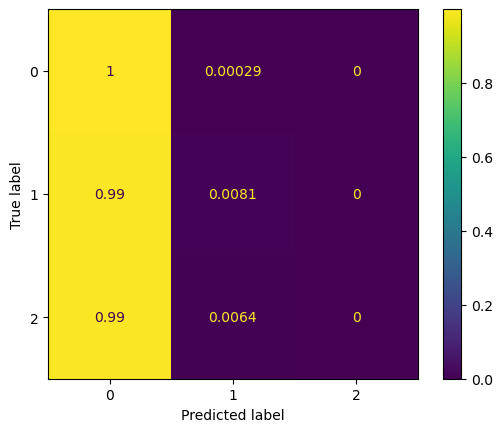

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.39520. Saving Model!
epoch 01, loss: 0.39262, acc: 0.89465, val_loss: 0.39520, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 02, loss: 0.39289, acc: 0.89465, val_loss: 0.39529, val_accuracy: 0.89464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 03, loss: 0.39230, acc: 0.89468, val_loss: 0.39606, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 04, loss: 0.39203, acc: 0.89460, val_loss: 0.39754, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 05, loss: 0.39171, acc: 0.89457, val_loss: 0.39899, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 06, loss: 0.39152, acc: 0.89460, val_loss: 0.40032, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 07, loss: 0.39132, acc: 0.89457, val_loss: 0.40105, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.79it/s]


epoch 08, loss: 0.39102, acc: 0.89454, val_loss: 0.40157, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 09, loss: 0.39079, acc: 0.89457, val_loss: 0.40194, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 10, loss: 0.39059, acc: 0.89457, val_loss: 0.40229, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s]


epoch 11, loss: 0.39040, acc: 0.89457, val_loss: 0.40252, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 12, loss: 0.39017, acc: 0.89460, val_loss: 0.40276, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 13, loss: 0.38994, acc: 0.89460, val_loss: 0.40311, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 14, loss: 0.38972, acc: 0.89460, val_loss: 0.40350, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 15, loss: 0.38951, acc: 0.89460, val_loss: 0.40384, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 16, loss: 0.38929, acc: 0.89460, val_loss: 0.40412, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 17, loss: 0.38906, acc: 0.89460, val_loss: 0.40436, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 18, loss: 0.38884, acc: 0.89460, val_loss: 0.40458, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 19, loss: 0.38863, acc: 0.89460, val_loss: 0.40479, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


epoch 20, loss: 0.38842, acc: 0.89460, val_loss: 0.40500, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 21, loss: 0.38820, acc: 0.89460, val_loss: 0.40518, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 22, loss: 0.38799, acc: 0.89460, val_loss: 0.40539, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 23, loss: 0.38779, acc: 0.89462, val_loss: 0.40561, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 24, loss: 0.38758, acc: 0.89462, val_loss: 0.40579, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 25, loss: 0.38737, acc: 0.89462, val_loss: 0.40594, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 26, loss: 0.38716, acc: 0.89462, val_loss: 0.40610, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 27, loss: 0.38695, acc: 0.89462, val_loss: 0.40629, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 28, loss: 0.38675, acc: 0.89465, val_loss: 0.40649, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 29, loss: 0.38656, acc: 0.89468, val_loss: 0.40665, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 30, loss: 0.38636, acc: 0.89468, val_loss: 0.40681, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


epoch 31, loss: 0.38615, acc: 0.89468, val_loss: 0.40698, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 32, loss: 0.38596, acc: 0.89468, val_loss: 0.40716, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 33, loss: 0.38575, acc: 0.89468, val_loss: 0.40738, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 34, loss: 0.38555, acc: 0.89468, val_loss: 0.40760, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 35, loss: 0.38535, acc: 0.89468, val_loss: 0.40781, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 36, loss: 0.38514, acc: 0.89468, val_loss: 0.40795, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 37, loss: 0.38495, acc: 0.89468, val_loss: 0.40806, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 38, loss: 0.38474, acc: 0.89468, val_loss: 0.40822, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 39, loss: 0.38454, acc: 0.89468, val_loss: 0.40846, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 40, loss: 0.38432, acc: 0.89468, val_loss: 0.40869, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 41, loss: 0.38412, acc: 0.89468, val_loss: 0.40886, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 42, loss: 0.38391, acc: 0.89468, val_loss: 0.40899, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 43, loss: 0.38371, acc: 0.89468, val_loss: 0.40911, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 44, loss: 0.38351, acc: 0.89468, val_loss: 0.40929, val_accuracy: 0.89411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 45, loss: 0.38329, acc: 0.89465, val_loss: 0.40957, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 46, loss: 0.38310, acc: 0.89465, val_loss: 0.40977, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 47, loss: 0.38288, acc: 0.89465, val_loss: 0.40990, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 48, loss: 0.38265, acc: 0.89465, val_loss: 0.40999, val_accuracy: 0.89438


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 49, loss: 0.38243, acc: 0.89468, val_loss: 0.41011, val_accuracy: 0.89438


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [36]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 500
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LogisticRegression
    lr = LogisticRegression(solver='liblinear', random_state=0)
    lr.fit(X_train, y_train)
    linear_pred = lr.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # RidgeClassifier
    clf = RidgeClassifier(alpha=1.0)
    clf.fit(X_train, y_train)
    ridge_pred = clf.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GradientBoostingClassifier
    reg = GradientBoostingClassifier(random_state=0)
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
    new_data = np.array([linear_pred.squeeze(),ridge_pred.squeeze(),regr_pred.squeeze(),reg_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(CatBoost_pred))
    
    
    accuracy=accuracy_score(y_test, CatBoost_pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,CatBoost_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,CatBoost_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, CatBoost_pred)

    cm = confusion_matrix(y_test, CatBoost_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig("./ConfusionMatrix_reward1/"+filename+".png")
    plt.show()
    
    i=i+1

In [ ]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

In [ ]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./ConfusionMatrix_reward1/PFMatrix_ensemble2_final2_grid_reward1_notsmote.xlsx')

In [ ]:
new_data

In [ ]:
lgbm_pred

In [ ]:
y_test